<a href="https://colab.research.google.com/github/mohammadkaifee/Credit-Card-Default-Prediction/blob/main/Credit_Card_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting whether a customer will default on his/her credit card </u></b>

## <b> Problem Description </b>

### This project is aimed at predicting the case of customers default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. We can use the [K-S chart](https://www.listendata.com/2019/07/KS-Statistics-Python.html) to evaluate which customers will default on their credit card payments


## <b> Data Description </b>

### <b>Attribute Information: </b>

### This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* ### X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* ### X2: Gender (1 = male; 2 = female).
* ### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* ### X4: Marital status (1 = married; 2 = single; 3 = others).
* ### X5: Age (year).
* ### X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* ### X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* ### X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [1]:
import pandas as pd
import numpy as np

#for data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':100})

#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Modelling
#Train-Test Split
from sklearn.model_selection import train_test_split
#Grid Search for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, f1_score, recall_score,roc_curve, classification_report

#to ignore warnings
import warnings    
warnings.filterwarnings('ignore')

import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Importing the Credit Card Default Dataset
df=pd.read_csv('/content/drive/MyDrive/AlmaBatter/Capstone_Projects/Credit_Card_Default_Prediction_Classification_ML/default of credit card client.csv')
df = df.sample(n=5000,replace =False,random_state=1)

In [4]:
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
10747  10748     310000    1          3         1   32      0      0      0   
12573  12574      10000    2          3         1   49     -1     -1     -2   
29676  29677      50000    1          2         1   28     -1     -1     -1   
8856    8857      80000    2          3         1   52      2      2      3   
21098  21099     270000    1          1         2   34      1      2      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
10747      0  ...      84373      57779      14163      8295      6000   
12573     -1  ...       1690       1138        930         0         0   
29676      0  ...      45975       1300      43987         0     46257   
8856       3  ...      40748      39816      40607      3700      1600   
21098      0  ...      22448      15490      17343         0      4000   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
10747      4000      3000      1000      2000                           0  
12573      2828         0       182         0                           1  
29676      2200      1300     43987      1386                           0  
8856       1600         0      1600      1600                           1  
21098      2000         0      2000      2000                           0  

[5 rows x 25 columns]

In [5]:
df.rename(columns = {'PAY_0':'PAY_1', 'default payment next month':'default'}, inplace = True)

In [6]:
df.shape

(5000, 25)

#What do 0 and -2 mean in PAY_X columns?
From dataset documentation: PAY_1: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above). Notice code 0 and 2 are in the PAY_X columns but are not included in the data description. Also by doing the value_counts, it shows 0 is the most frequent observation.

After searching online, I realized the same question was asked by others, and the answer from the dataset contributor was:

###-2: No consumption;
###-1: Paid in full;
###0: The use of revolving credit, meaning the payment wasn't due, which makes sense that most customers were using the revolving credit.

In [7]:
# Sort the repayment status codes in PAY_X columns by melting them into 1 column
# Notice there are 2 undocumented codes: 0,-2

pay = df[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]
pay_melt = pd.melt(pay)
pay_melt['value'].value_counts()

 0    16039
-1     5859
-2     4024
 2     3087
 1      602
 3      245
 4       72
 7       42
 5       19
 6        8
 8        3
Name: value, dtype: int64

#Check missing values, column type and column names
There is no missing value, all columns have the correct type, and all columns are named consistently since we have renamed the last inconsistent column name to default.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 10747 to 7450
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         5000 non-null   int64
 1   LIMIT_BAL  5000 non-null   int64
 2   SEX        5000 non-null   int64
 3   EDUCATION  5000 non-null   int64
 4   MARRIAGE   5000 non-null   int64
 5   AGE        5000 non-null   int64
 6   PAY_1      5000 non-null   int64
 7   PAY_2      5000 non-null   int64
 8   PAY_3      5000 non-null   int64
 9   PAY_4      5000 non-null   int64
 10  PAY_5      5000 non-null   int64
 11  PAY_6      5000 non-null   int64
 12  BILL_AMT1  5000 non-null   int64
 13  BILL_AMT2  5000 non-null   int64
 14  BILL_AMT3  5000 non-null   int64
 15  BILL_AMT4  5000 non-null   int64
 16  BILL_AMT5  5000 non-null   int64
 17  BILL_AMT6  5000 non-null   int64
 18  PAY_AMT1   5000 non-null   int64
 19  PAY_AMT2   5000 non-null   int64
 20  PAY_AMT3   5000 non-null   int64
 21  PAY_AMT4  

In [9]:
df.describe().T

count         mean            std      min       25%       50%  \
ID         5000.0   14862.9204    8680.023278      3.0   7193.75   14871.0   
LIMIT_BAL  5000.0  169306.0000  131525.503822  10000.0  50000.00  140000.0   
SEX        5000.0       1.5976       0.490431      1.0      1.00       2.0   
EDUCATION  5000.0       1.8514       0.794383      0.0      1.00       2.0   
MARRIAGE   5000.0       1.5504       0.521837      0.0      1.00       2.0   
AGE        5000.0      35.5658       9.273924     21.0     28.00      34.0   
PAY_1      5000.0      -0.0386       1.088001     -2.0     -1.00       0.0   
PAY_2      5000.0      -0.1472       1.173971     -2.0     -1.00       0.0   
PAY_3      5000.0      -0.1690       1.191101     -2.0     -1.00       0.0   
PAY_4      5000.0      -0.2192       1.170566     -2.0     -1.00       0.0   
PAY_5      5000.0      -0.2706       1.137732     -2.0     -1.00       0.0   
PAY_6      5000.0      -0.2848       1.164972     -2.0     -1.00       0.0   
BILL_AMT1  5000.0   51286.2714   74472.533245 -15308.0   3651.25   22380.0   
BILL_AMT2  5000.0   49120.0378   71714.254732 -33350.0   2917.00   20887.0   
BILL_AMT3  5000.0   47114.2844   72826.509741 -34041.0   2778.00   19848.0   
BILL_AMT4  5000.0   43592.9878   65300.378231 -81334.0   2485.75   19191.5   
BILL_AMT5  5000.0   40624.5316   61031.613035 -81334.0   1745.00   18201.5   
BILL_AMT6  5000.0   39100.7134   59561.490754 -73895.0   1244.50   17079.0   
PAY_AMT1   5000.0    5712.7126   15974.245000      0.0   1000.00    2089.0   
PAY_AMT2   5000.0    6168.2860   29455.167319      0.0    799.75    2011.5   
PAY_AMT3   5000.0    5847.4420   19111.264928      0.0    396.00    1811.5   
PAY_AMT4   5000.0    5219.8544   16468.053140      0.0    316.00    1520.0   
PAY_AMT5   5000.0    5081.8398   16284.349383      0.0    278.50    1500.0   
PAY_AMT6   5000.0    5716.6550   20330.666372      0.0    169.25    1490.0   
default    5000.0       0.2206       0.414693      0.0      0.00       0.0   

                 75%        max  
ID          22367.75    29993.0  
LIMIT_BAL  240000.00   750000.0  
SEX             2.00        2.0  
EDUCATION       2.00        6.0  
MARRIAGE        2.00        3.0  
AGE            41.00       73.0  
PAY_1           0.00        7.0  
PAY_2           0.00        8.0  
PAY_3           0.00        8.0  
PAY_4           0.00        7.0  
PAY_5           0.00        7.0  
PAY_6           0.00        7.0  
BILL_AMT1   66651.50   746814.0  
BILL_AMT2   64292.75   624475.0  
BILL_AMT3   59091.00  1664089.0  
BILL_AMT4   52586.75   628699.0  
BILL_AMT5   50074.25   508213.0  
BILL_AMT6   48956.00   513798.0  
PAY_AMT1     5000.00   405016.0  
PAY_AMT2     5000.00  1684259.0  
PAY_AMT3     5000.00   508229.0  
PAY_AMT4     4137.75   331788.0  
PAY_AMT5     4200.00   379267.0  
PAY_AMT6     4000.00   528666.0  
default         0.00        1.0



1.  There are 5000 distinct credit card clients.
2.  The average value for the amount of credit card limit is 169306.00. The standard deviation is unusually large, max value being 131525.503822.

3.  Education Level is mostly graduate school and university.
4.  Most of the clients are either married or single .

5.   Average age is 35.5 years, with a standard deviation of 9.2

6.   As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.2206 means that there are almost 22.06% of credit card contracts that will default next month (will verify this in the next sections of this analysis).







In [10]:
df.index = df['ID']

In [11]:
df.drop('ID',axis=1,inplace=True)

In [12]:
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
ID                                                                            
10748     310000    1          3         1   32      0      0      0      0   
12574      10000    2          3         1   49     -1     -1     -2     -1   
29677      50000    1          2         1   28     -1     -1     -1      0   
8857       80000    2          3         1   52      2      2      3      3   
21099     270000    1          1         2   34      1      2      0      0   

       PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
ID            ...                                                        
10748      0  ...      84373      57779      14163      8295      6000   
12574      2  ...       1690       1138        930         0         0   
29677     -1  ...      45975       1300      43987         0     46257   
8857       3  ...      40748      39816      40607      3700      1600   
21099      2  ...      22448      15490      17343         0      4000   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
ID                                                      
10748      4000      3000      1000      2000        0  
12574      2828         0       182         0        1  
29677      2200      1300     43987      1386        0  
8857       1600         0      1600      1600        1  
21099      2000         0      2000      2000        0  

[5 rows x 24 columns]

In [13]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [14]:
df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

#Step2: Data Visualisation and Analysis

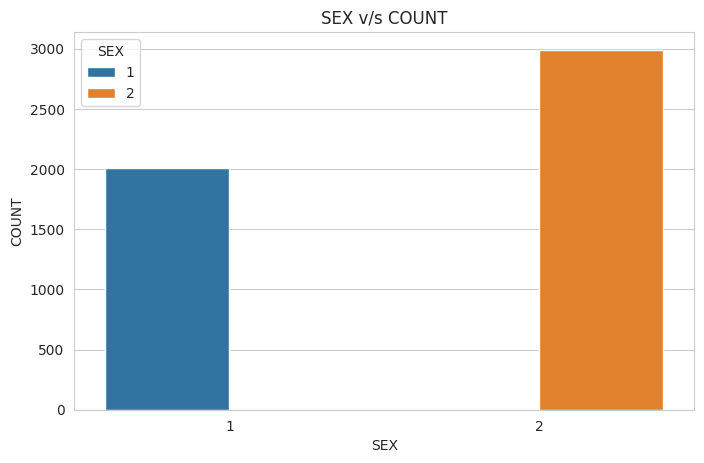

In [15]:
sns.set_style('whitegrid')
sns.countplot(x='SEX', data=df, hue='SEX')
plt.xlabel('SEX')
plt.ylabel('COUNT')
plt.title('SEX v/s COUNT')
plt.show()

**Number of Male credit holder is less than Female**

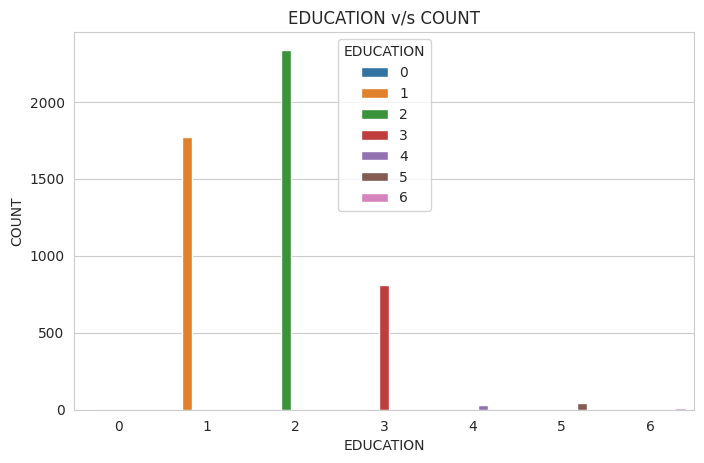

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='EDUCATION', data=df, hue='EDUCATION')
plt.xlabel('EDUCATION')
plt.ylabel('COUNT')
plt.title('EDUCATION v/s COUNT')
plt.show()

**More number of credit holders are university students followed by Graduates and then High school students**

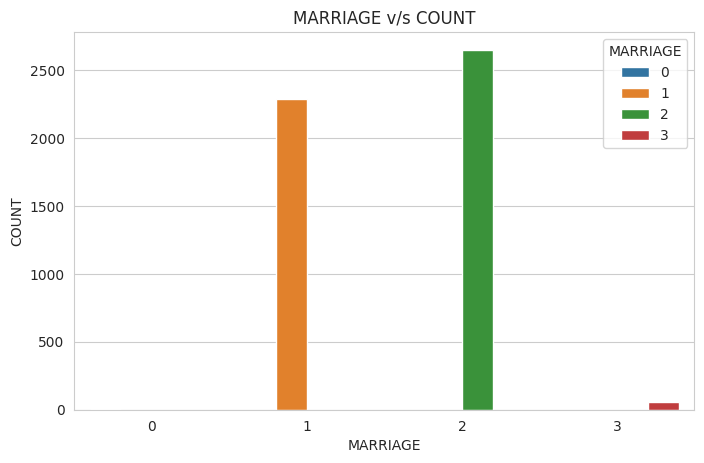

In [17]:
sns.set_style('whitegrid')
sns.countplot(x='MARRIAGE', data=df, hue='MARRIAGE')
plt.xlabel('MARRIAGE')
plt.ylabel('COUNT')
plt.title('MARRIAGE v/s COUNT')
plt.show()

**More number of credit cards holder are Married**

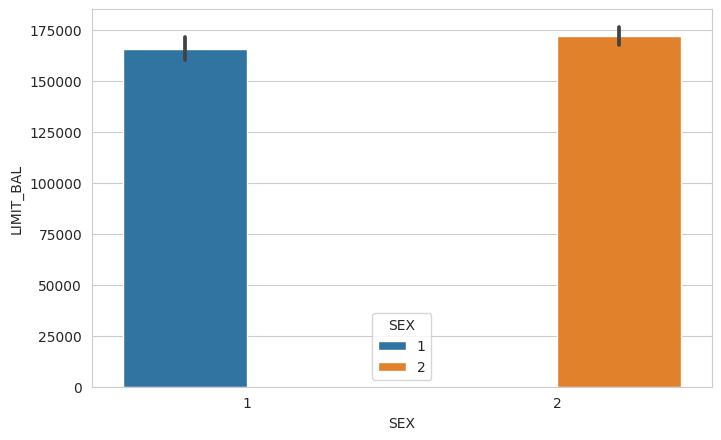

In [18]:
sns.barplot(x='SEX',y='LIMIT_BAL', hue='SEX', data=df)
plt.show()

**Number of male and female card holders are almost same.**

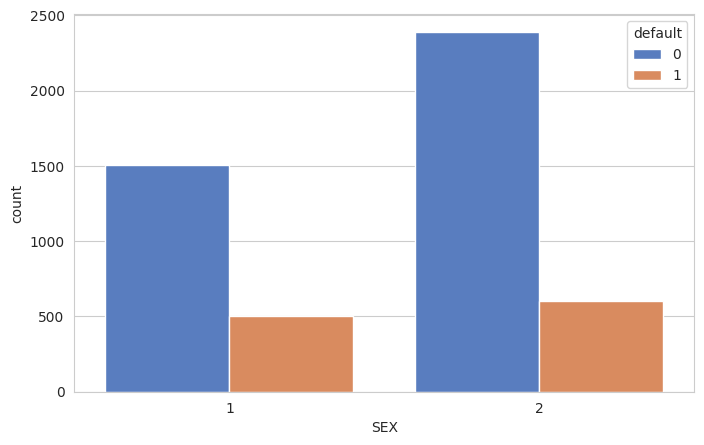

In [19]:
# Checking the number of counts of defaulters and non defaulters sexwise
sns.countplot(x='SEX', data=df, hue='default', palette="muted")
plt.show()

It is evident from the above output that females have overall less default payments wrt males

Non-Defaults have a higher proportion of Females (Sex=2)

In [20]:
def getColumnsNames(prefix):
    return [prefix+str(x) for x in range(1,7)]

In [21]:
getColumnsNames('PAY_')

['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

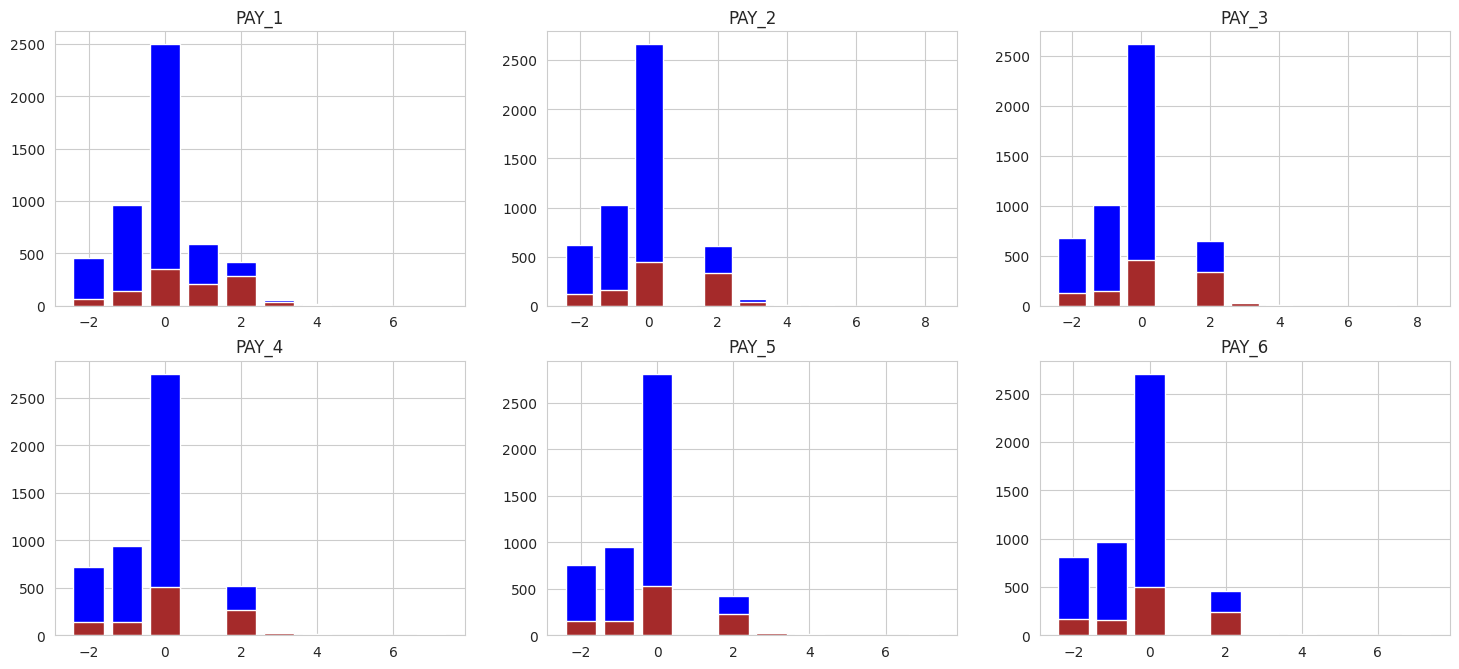

In [22]:
# PAY_1 , PAY_2 , PAY_3 , PAY_4 , PAY_5, PAY_6
pay_status_columns = getColumnsNames('PAY_')
figure, ax = plt.subplots(2,3)
figure.set_size_inches(18,8)

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3
    d = df[pay_status_columns[i]].value_counts()
    x = df[pay_status_columns[i]][(df['default']==1)].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='blue')
    ax[row,col].bar(x.index, x, align='center', color='brown')
    ax[row,col].set_title(pay_status_columns[i])  
plt.show()

The above figure shows bar plot for each month payment status which show the count of defaulters and non-defaulter.

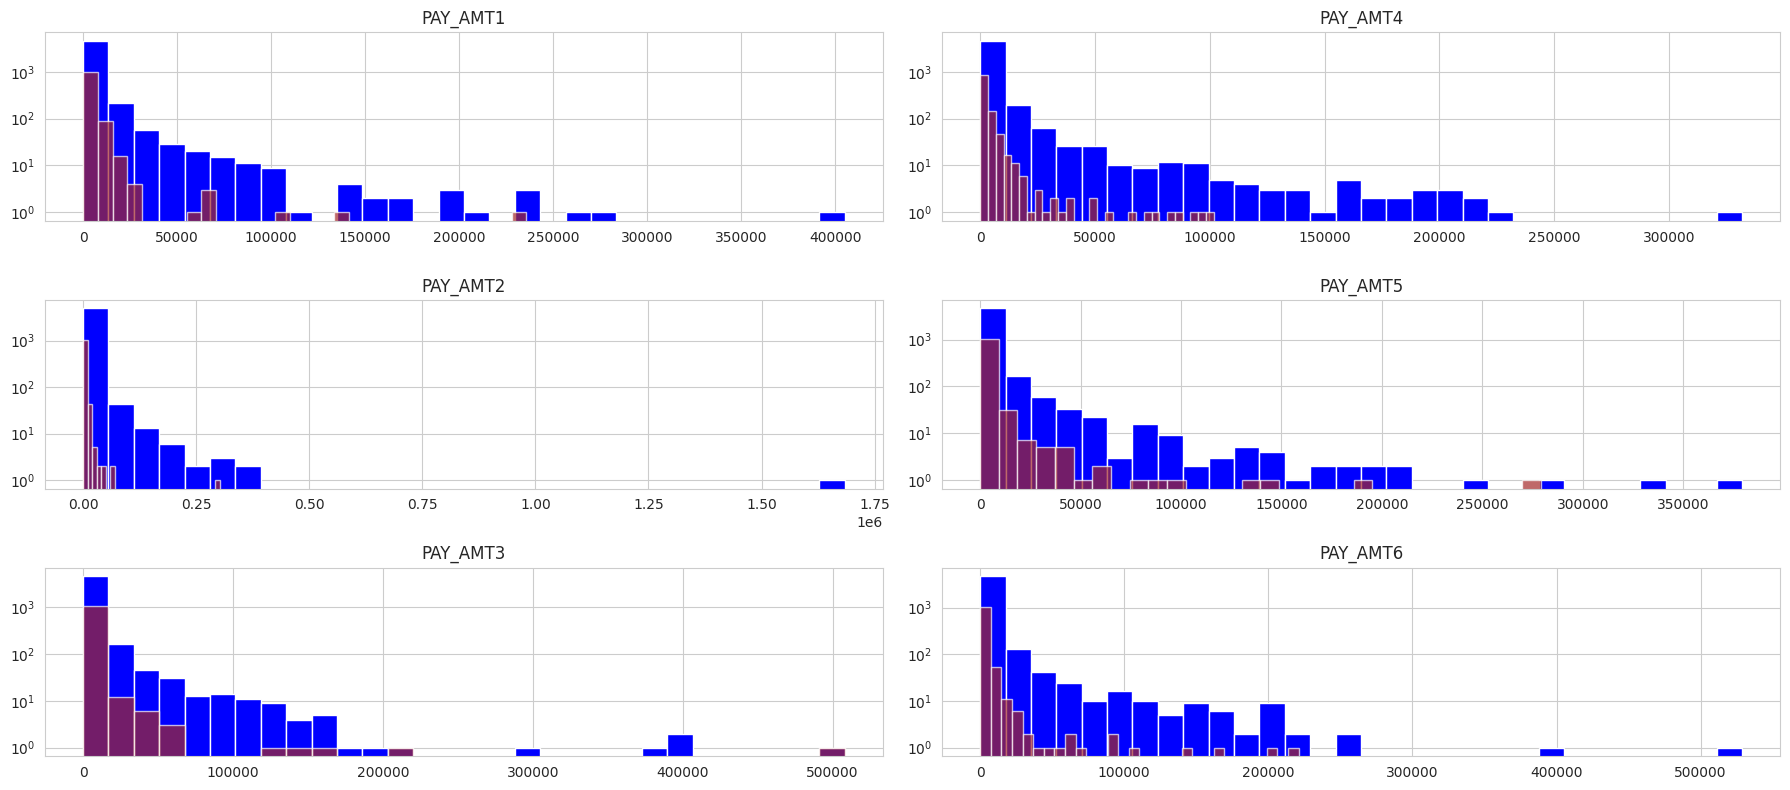

In [23]:
pay_amt_columns = getColumnsNames('PAY_AMT')
figure, ax = plt.subplots(3,2)
figure.set_size_inches(18,8)

for i in range(len(pay_status_columns)):
    row,col =  i%3, int(i/3)
   
    ax[row,col].hist(df[pay_amt_columns[i]], 30, color ='blue')
    ax[row,col].hist(df[pay_amt_columns[i]][(df['default']==1)],30,color='brown',alpha = 0.7)
    ax[row,col].set_title(pay_amt_columns[i])
    #adding scaling to make the graph more helpful
    ax[row,col].set_yscale('log', nonposy='clip')
plt.tight_layout()
plt.show()

**The above histogram shows the distribution of payment amount for each month explicitly for defaulters and non-defaulters**

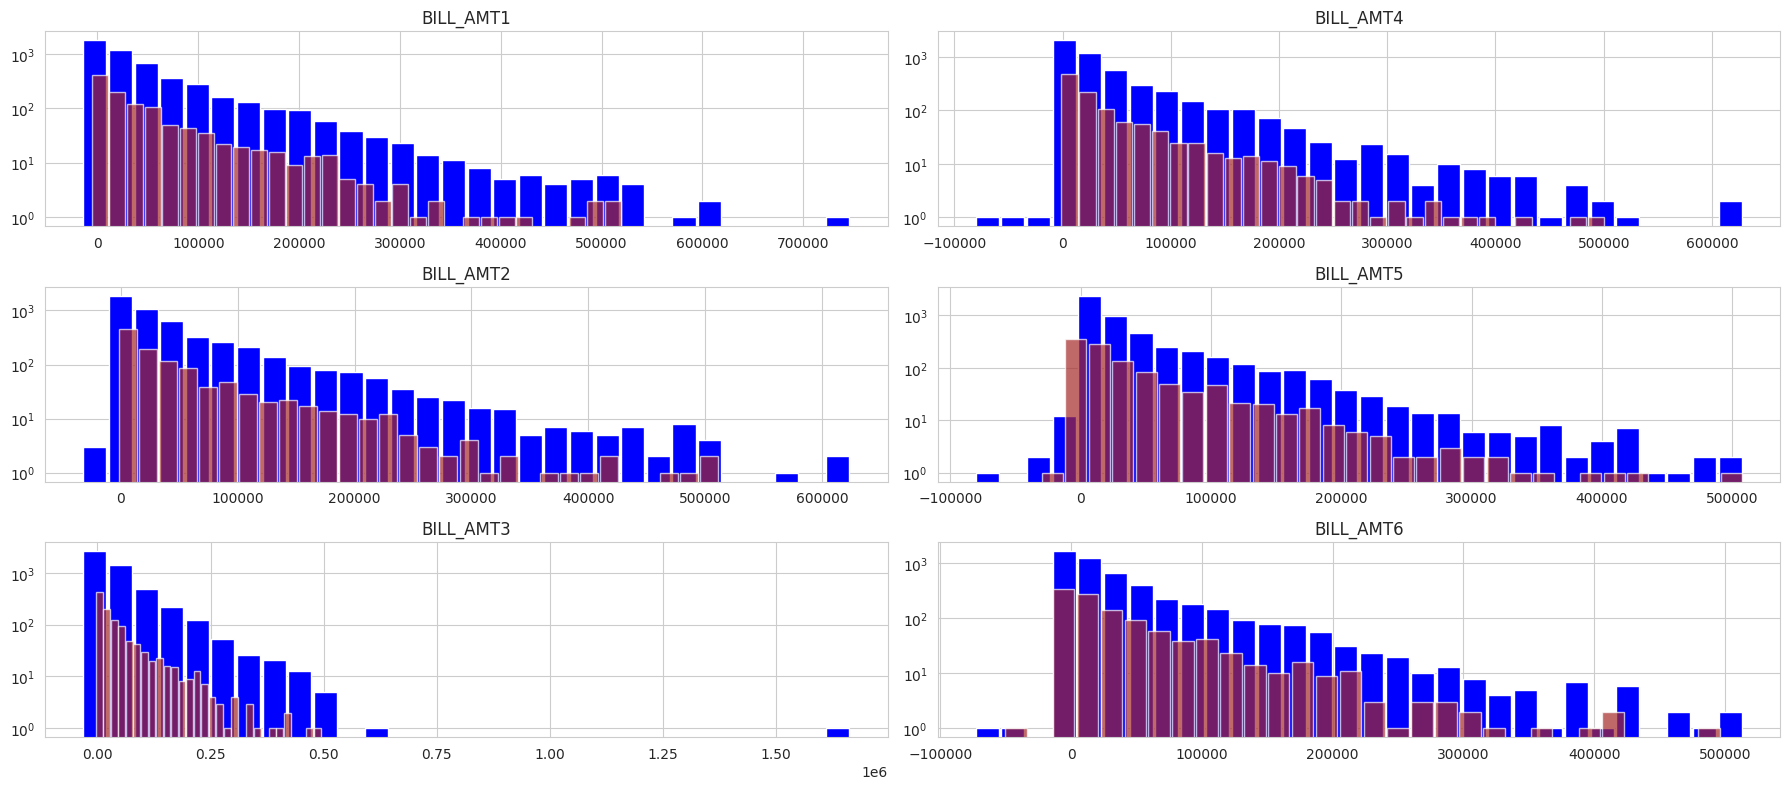

In [24]:
bill_atm_columns =  getColumnsNames('BILL_AMT')
figure, ax = plt.subplots(3,2)
figure.set_size_inches(18,8)

for i in range(len(pay_status_columns)):
    row,col =  i%3, int(i/3)
   
    ax[row,col].hist(df[bill_atm_columns[i]], 30, rwidth=0.9, color ='blue')
    ax[row,col].hist(df[bill_atm_columns[i]][(df['default']==1)],30,rwidth=0.9,color='brown',alpha = 0.7)
    ax[row,col].set_title(bill_atm_columns[i])
    #adding scaling to make the graph more helpful
    ax[row,col].set_yscale('log', nonposy='clip')
plt.tight_layout()
plt.show()

**The above histogram shows the distribution of Bill amount generated for each month explicitly for defaulters and non-defaulters**

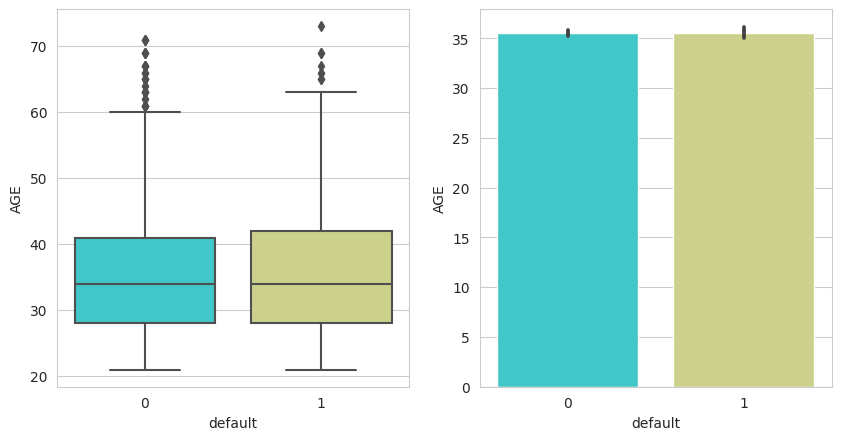

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(x='default',y='AGE',data=df,palette='rainbow')
plt.subplot(1,2,2)
sns.barplot(x='default',y='AGE',data=df,palette='rainbow')
plt.show()

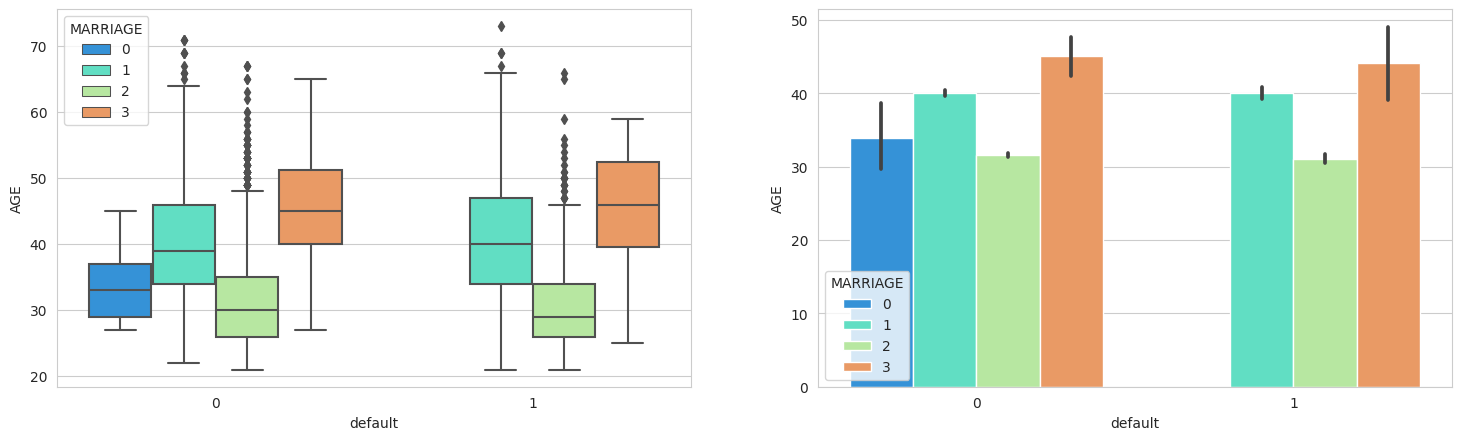

In [26]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.boxplot(x='default',hue='MARRIAGE', y='AGE',data=df,palette="rainbow")
plt.subplot(1,2,2)
sns.barplot(x='default',hue='MARRIAGE', y='AGE',data=df,palette="rainbow")
plt.show()

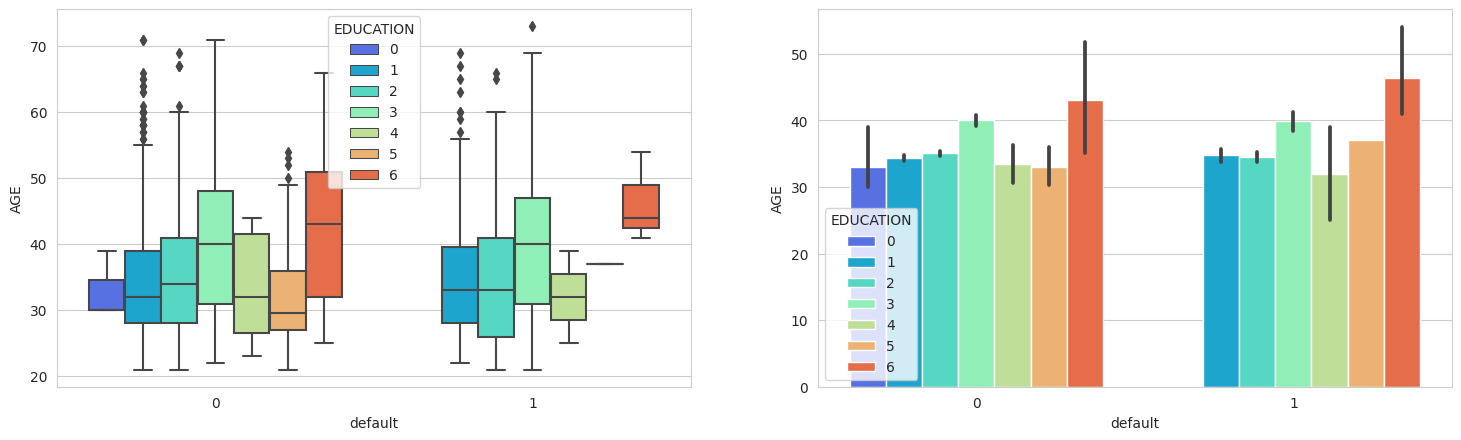

In [27]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.boxplot(x='default',hue='EDUCATION', y='AGE',data=df,palette="rainbow" )
plt.subplot(1,2,2)
sns.barplot(x='default',hue='EDUCATION', y='AGE',data=df,palette="rainbow")
plt.show()

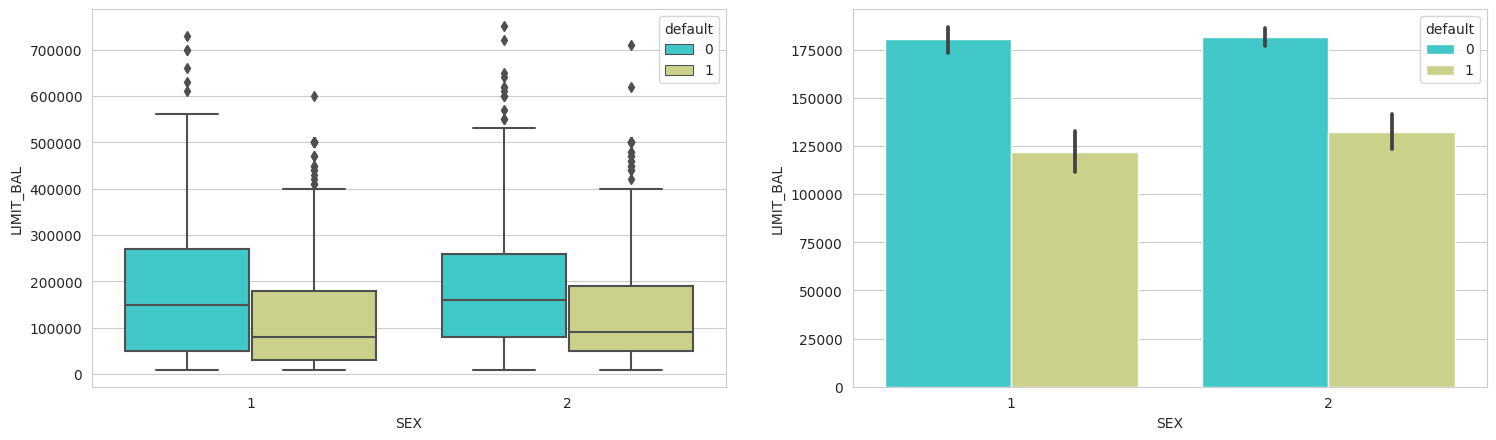

In [28]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.boxplot(x='SEX',hue='default', y='LIMIT_BAL',data=df,palette="rainbow")
plt.subplot(1,2,2)
sns.barplot(x='SEX',hue='default', y='LIMIT_BAL',data=df,palette="rainbow")
plt.show()

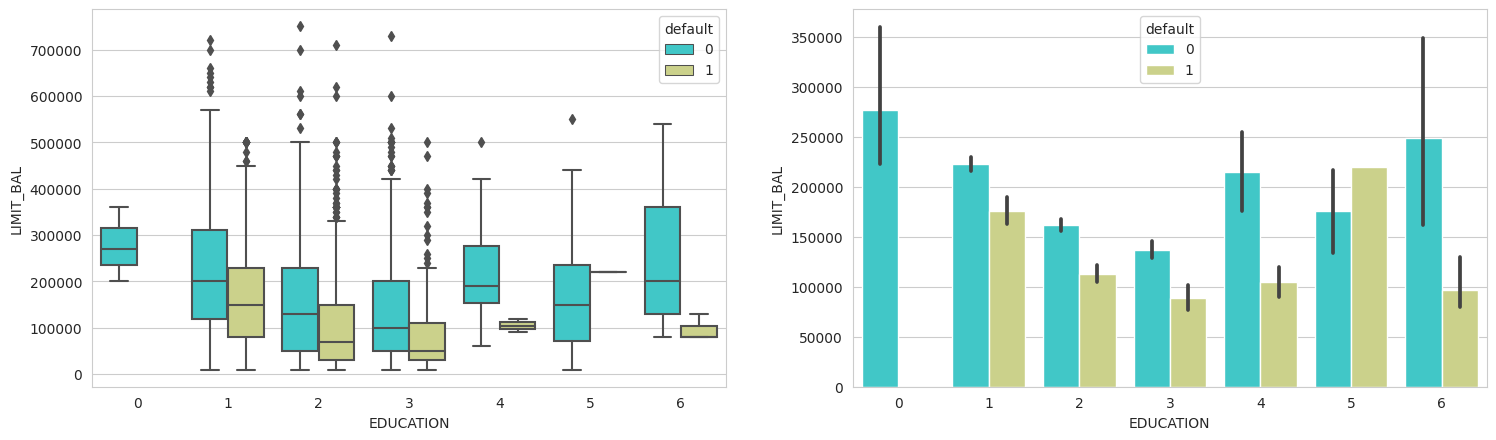

In [29]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.boxplot(x='EDUCATION',hue='default', y='LIMIT_BAL',data=df,palette="rainbow")
plt.subplot(1,2,2)
sns.barplot(x='EDUCATION',hue='default', y='LIMIT_BAL',data=df,palette="rainbow")
plt.show()

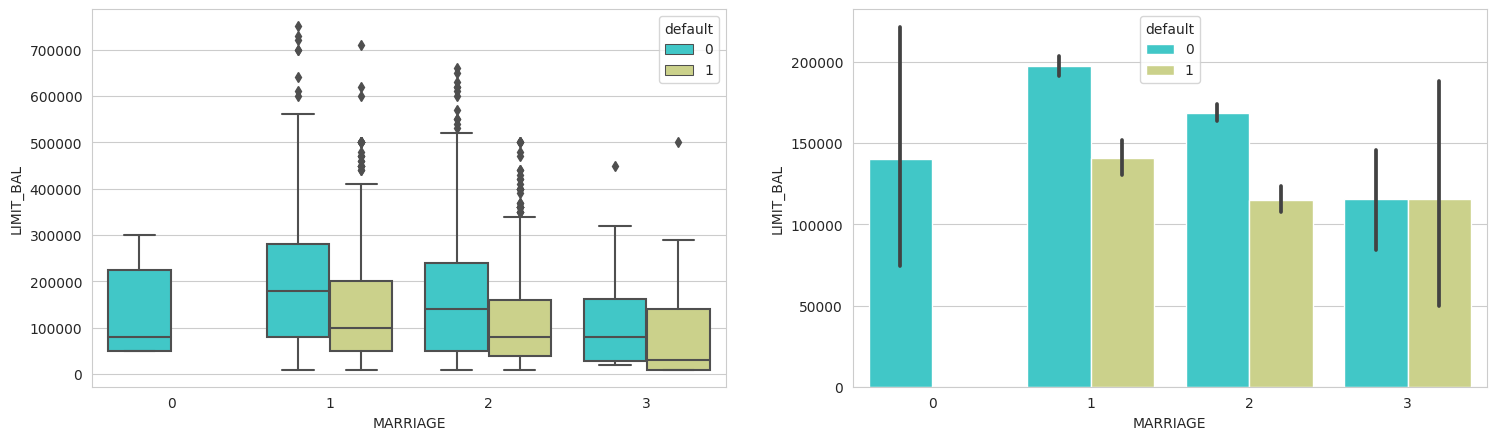

In [30]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.boxplot(x='MARRIAGE',hue='default', y='LIMIT_BAL',data=df,palette="rainbow")
plt.subplot(1,2,2)
sns.barplot(x='MARRIAGE',hue='default', y='LIMIT_BAL',data=df,palette="rainbow")
plt.show()

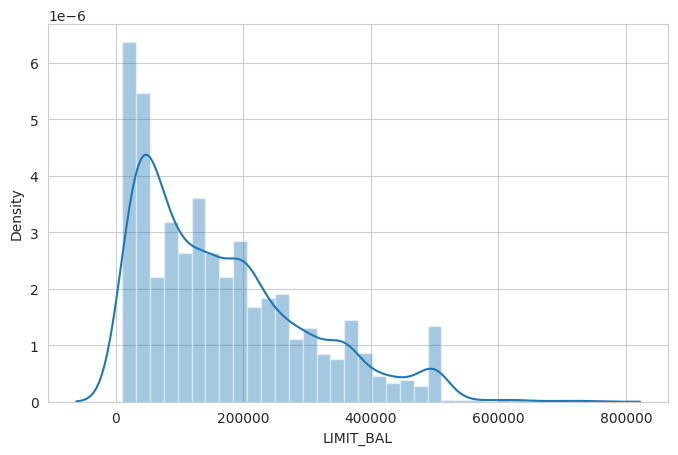

In [31]:
sns.distplot(df['LIMIT_BAL'],kde=True)
plt.show()

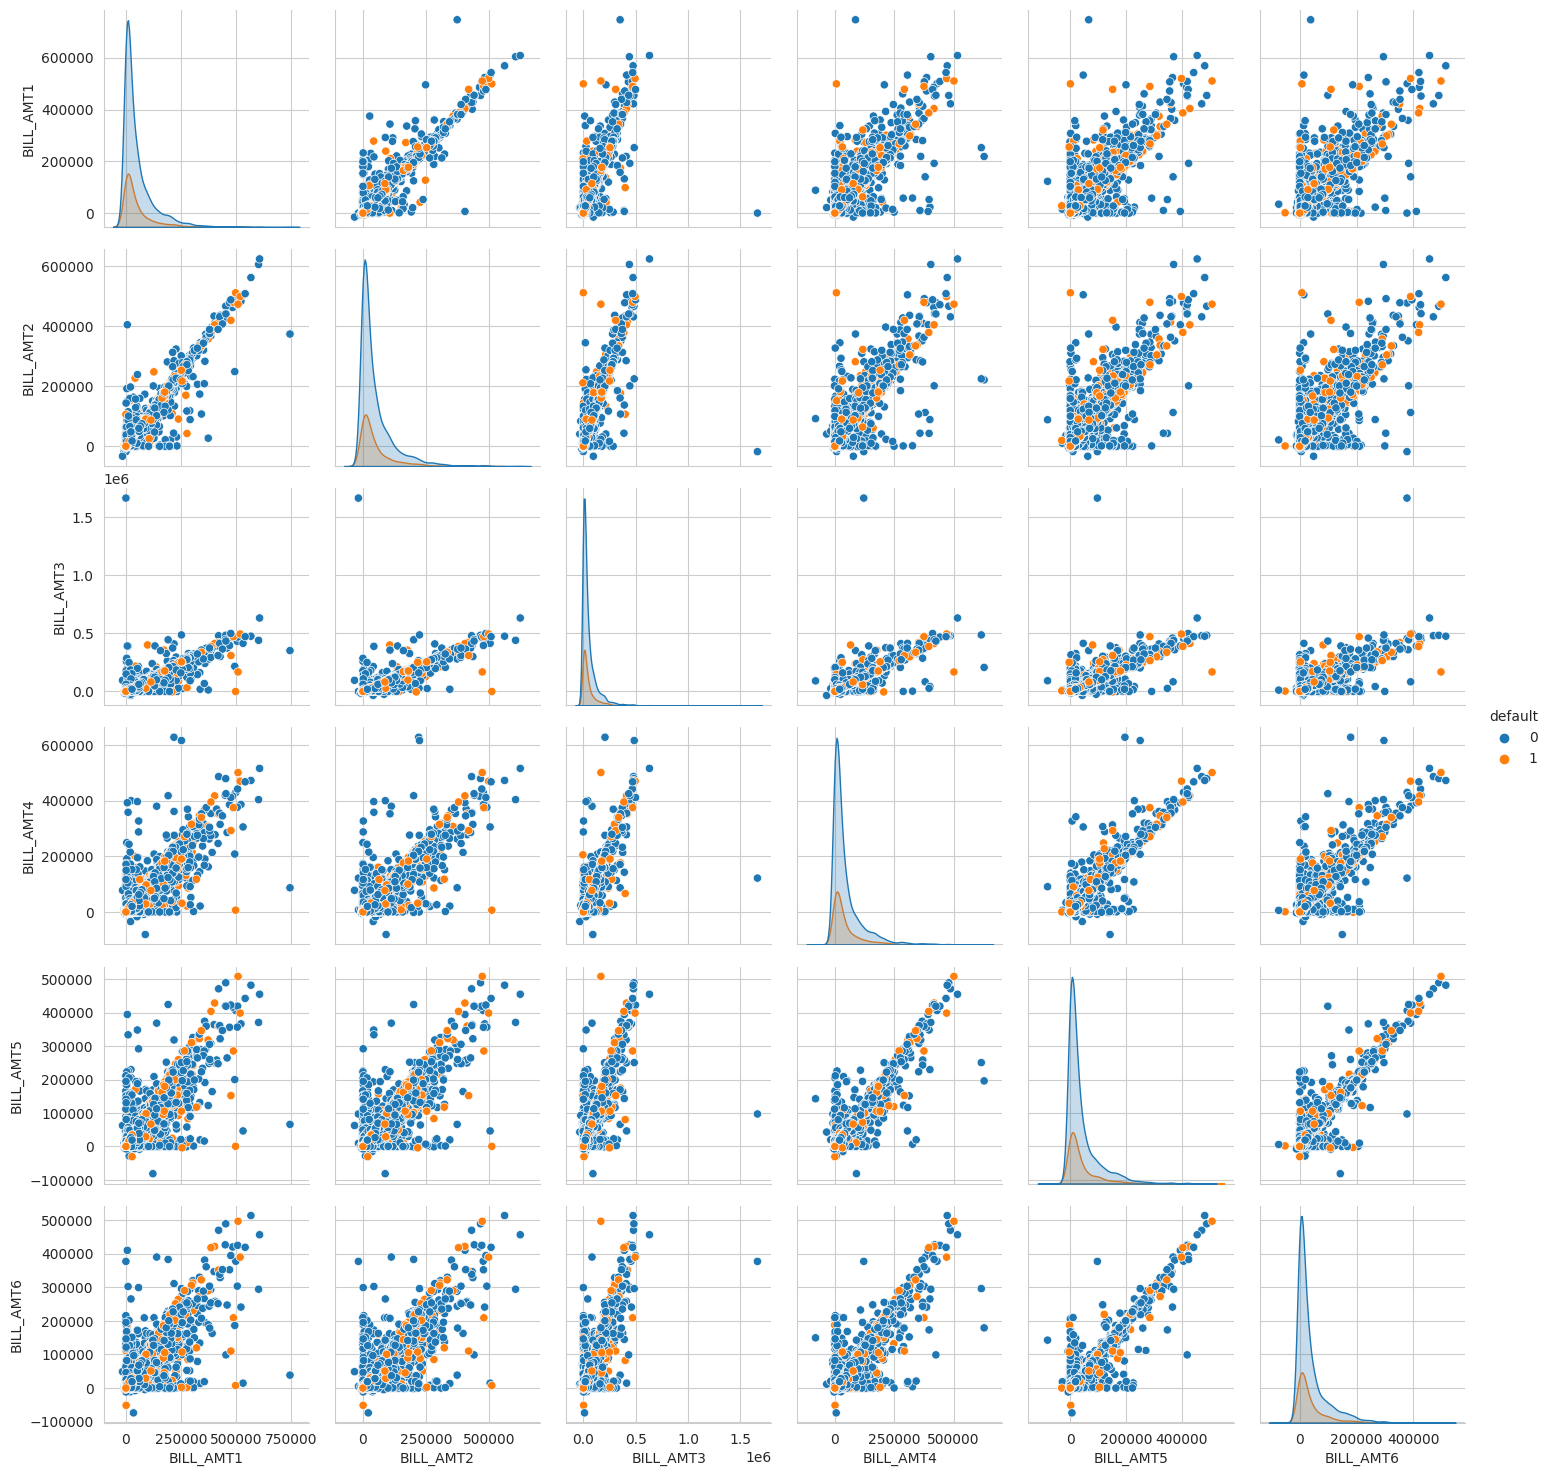

In [32]:
# plot columns with similar names to check the correlation
sns.pairplot(df, vars=df.columns[11:17], kind='scatter',hue= 'default')
plt.show()

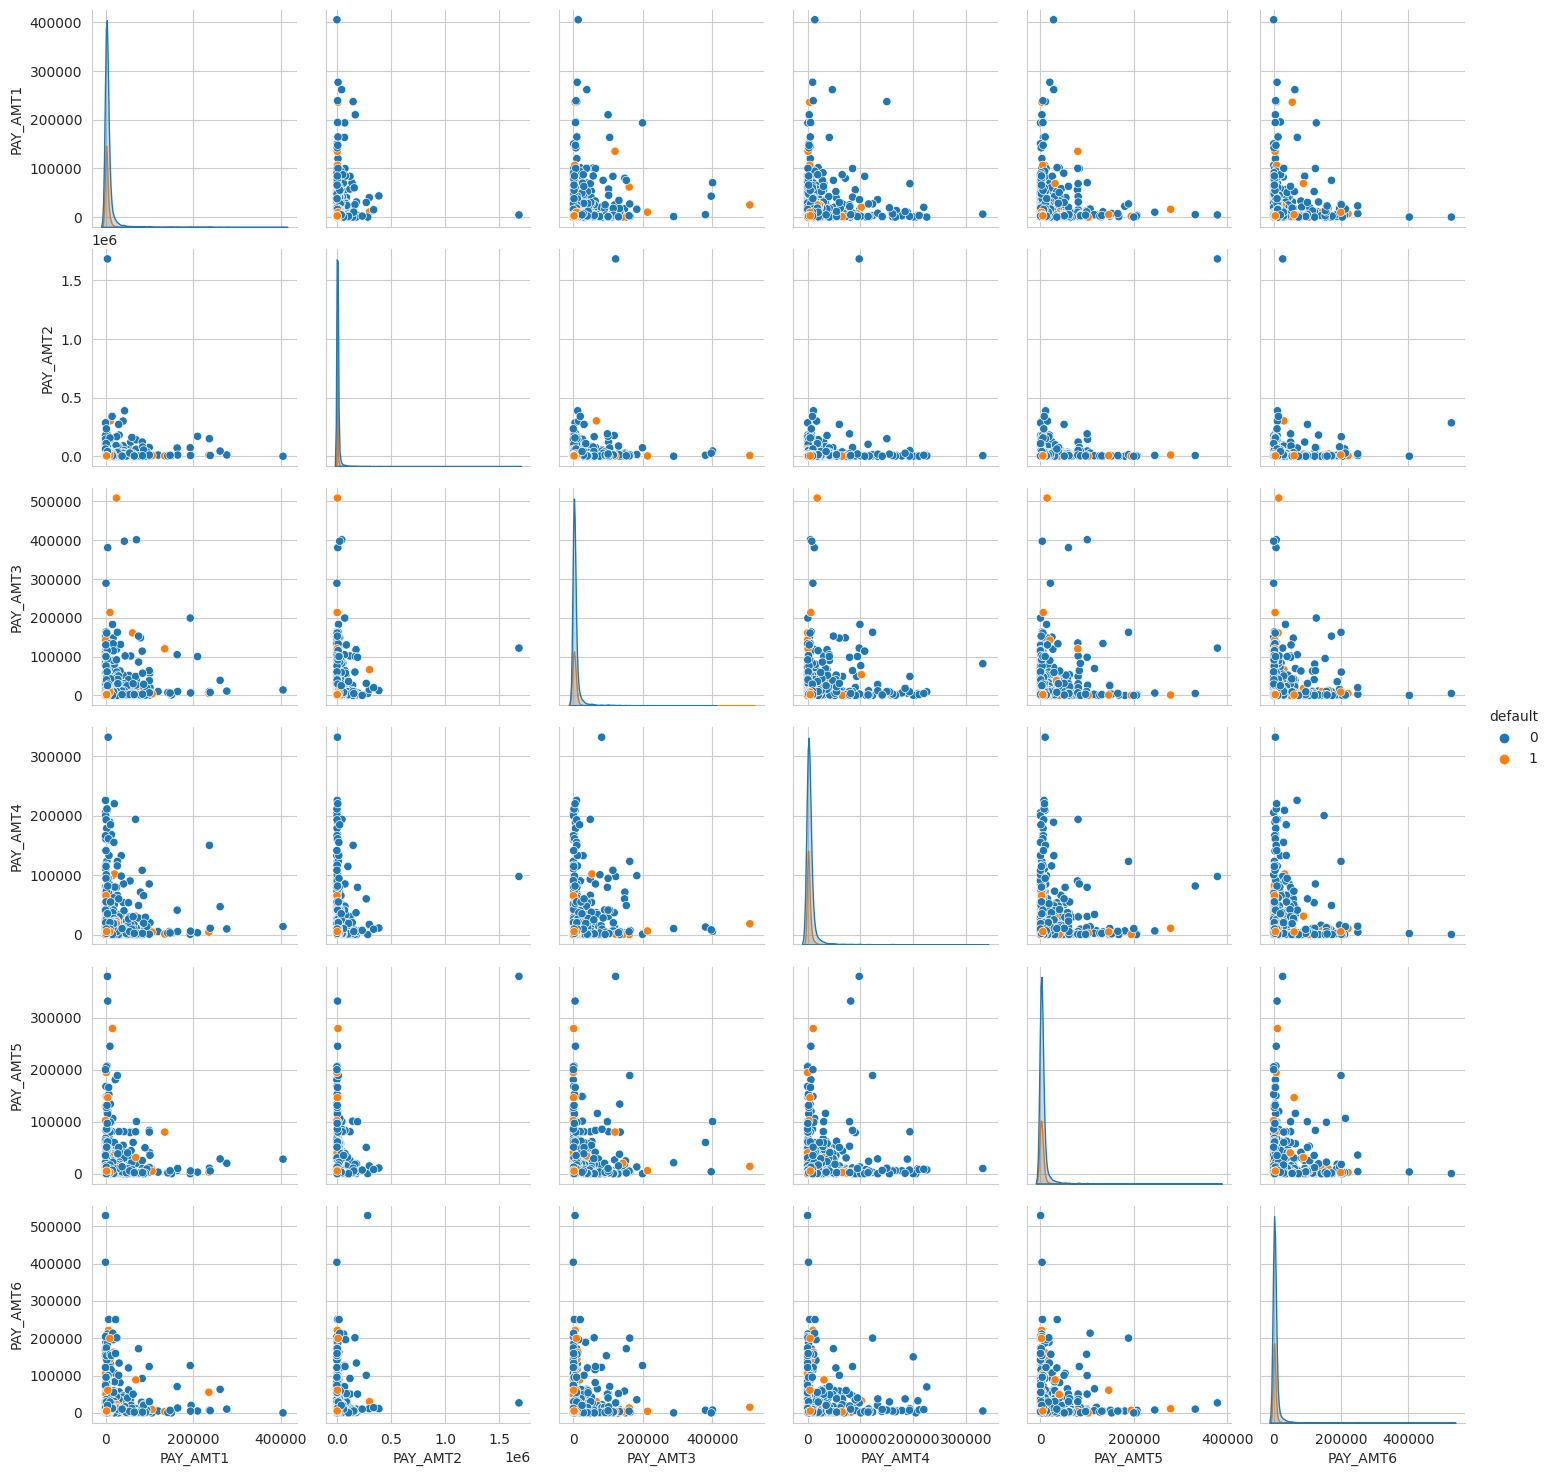

In [33]:
sns.pairplot(df, vars=df.columns[17:23],hue = 'default')
plt.show()

**Step3: Observing Correlation between features of the Dataset**

In [34]:
correlation = df.corr()

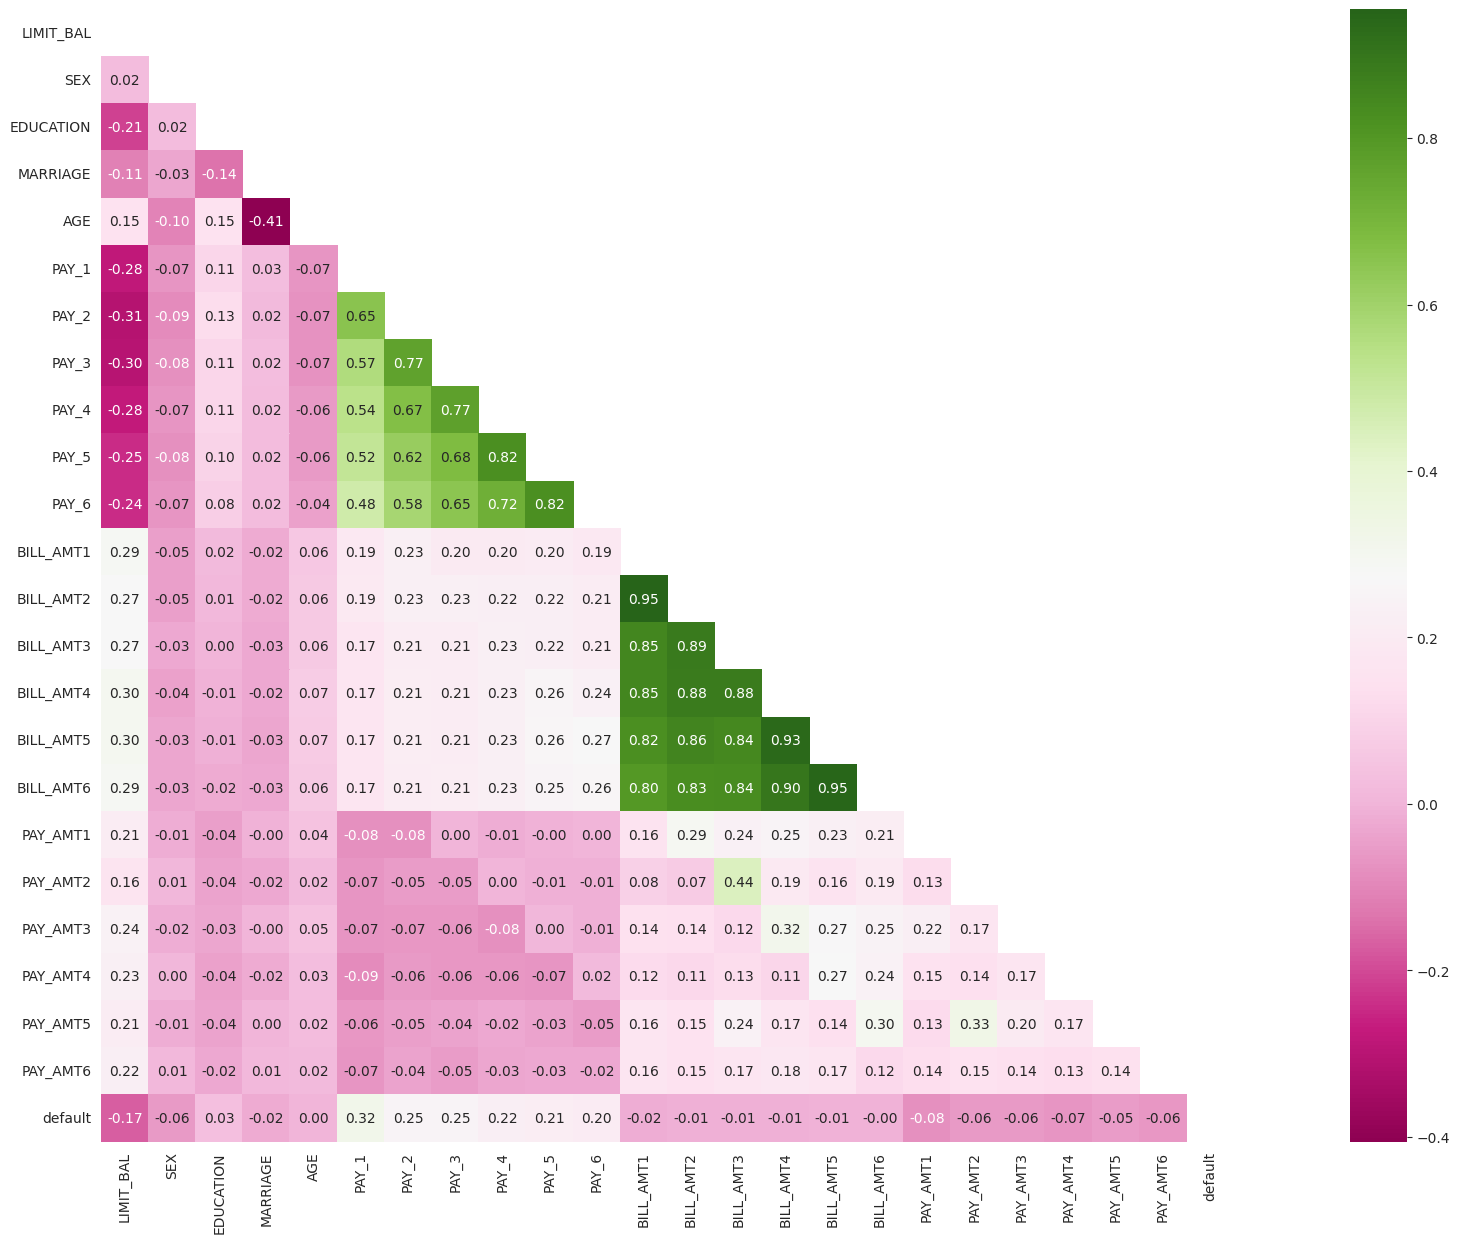

In [35]:
plt.figure(figsize=(30,15))
drop_Self = np.zeros_like(correlation)
drop_Self[np.triu_indices_from(drop_Self)] = True
sns.heatmap(correlation,cmap='PiYG', square=True, annot=True, fmt="2.2f",mask=drop_Self)
plt.show()

**So it looks like the PAY_1, PAY_X variables are the strongest predictors of default, followed by the LIMIT_BAL and PAY_AMT_X variables.**

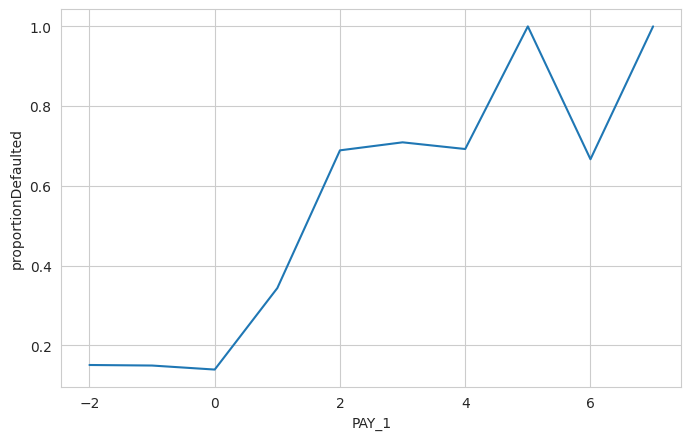

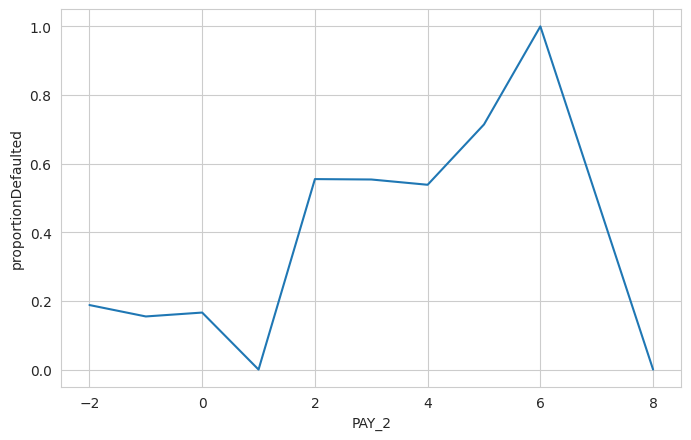

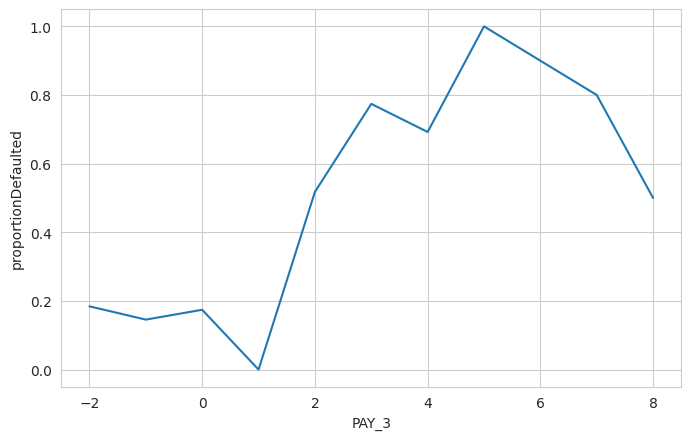

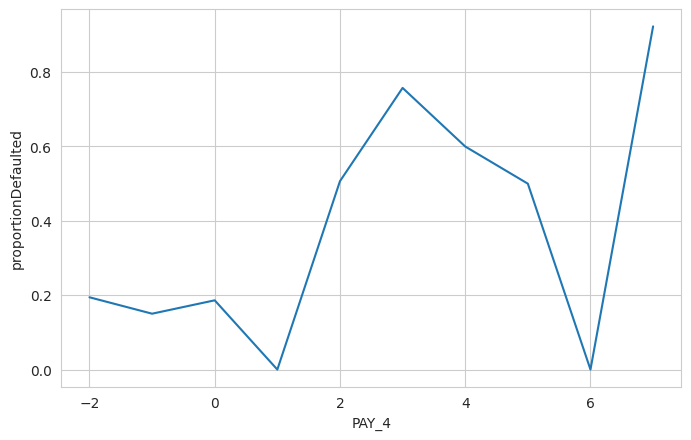

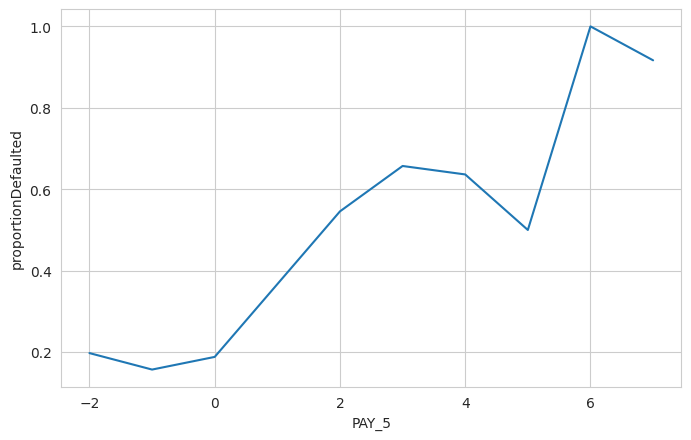

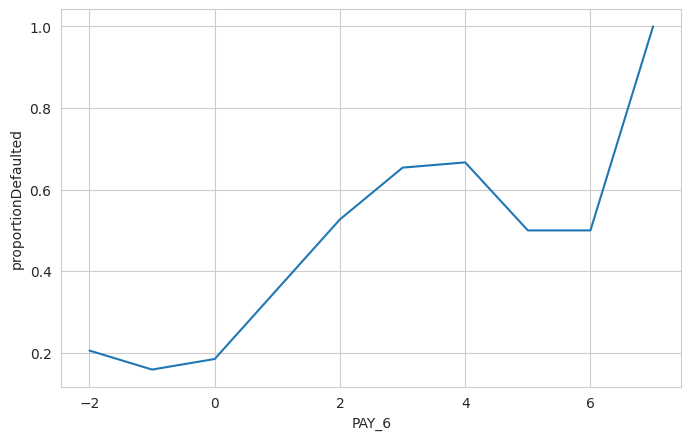

In [36]:
#Visualizing monthly repayment status(whether repayment occurred on time or delayed) versus credit default rate

plotDat1 = (df.groupby(['PAY_1']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'}))
plotDat1.sample(5)
plt.figure()
sns.lineplot(x = 'PAY_1', y = 'proportionDefaulted', data = plotDat1)

plotDat2 = (df.groupby(['PAY_2']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'}))
plt.figure()
sns.lineplot(x = 'PAY_2', y = 'proportionDefaulted', data = plotDat2)

plotDat3 = (df.groupby(['PAY_3']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'}))
plt.figure()
sns.lineplot(x = 'PAY_3', y = 'proportionDefaulted', data = plotDat3)

plotDat4 = (df.groupby(['PAY_4']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'}))
plt.figure()
sns.lineplot(x = 'PAY_4', y = 'proportionDefaulted', data = plotDat4)

plotDat5 = (df.groupby(['PAY_5']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'}))
plt.figure()
sns.lineplot(x = 'PAY_5', y = 'proportionDefaulted', data = plotDat5)

plotDat6 = (df.groupby(['PAY_6']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'}))
plt.figure()
sns.lineplot(x = 'PAY_6', y = 'proportionDefaulted', data = plotDat6)

plt.show()

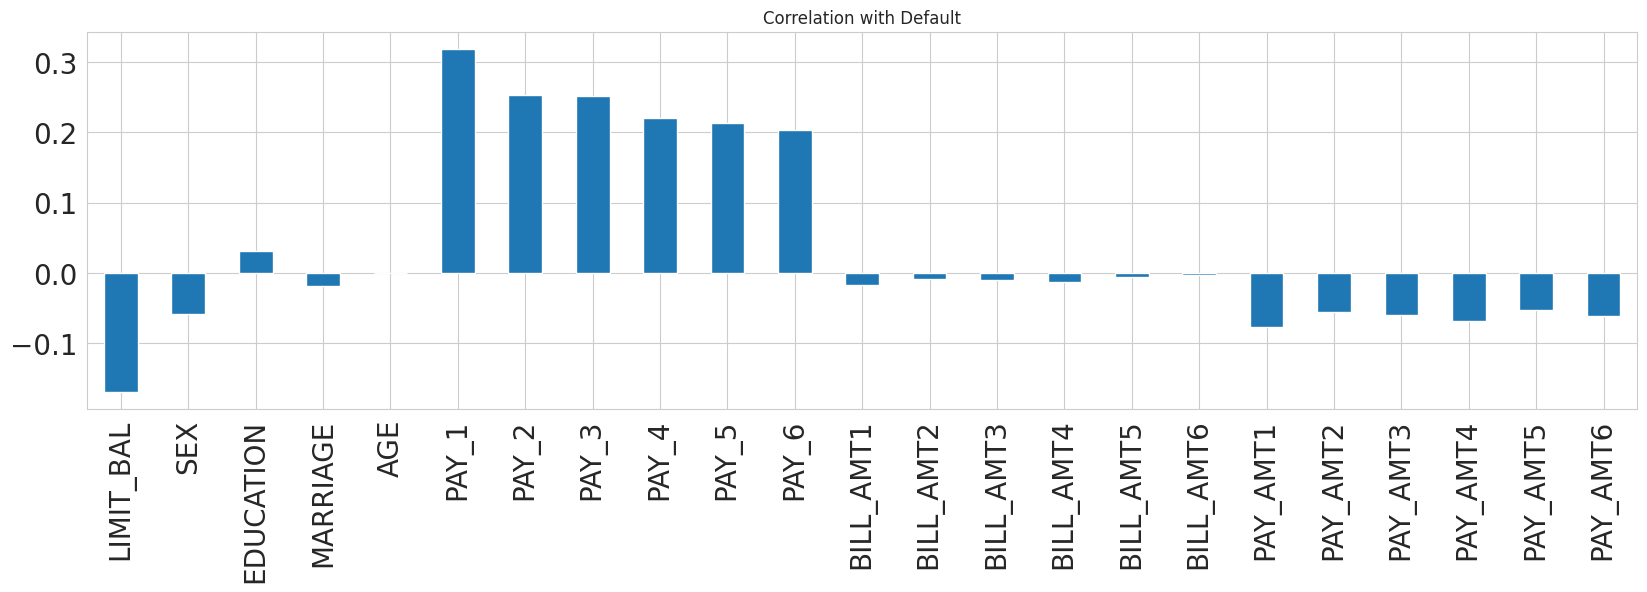

In [37]:
X = df.drop(['default'],axis=1)
X.corrwith(df['default']).plot.bar(figsize = (20, 5), title = "Correlation with Default", 
                                        fontsize = 20, rot = 90, grid = True)
plt.show()

It seems from the above graph is that most negatively correlated feature is LIMIT_BAL but we cannot blindly remove this feature because according to me it is very important feature for prediction.

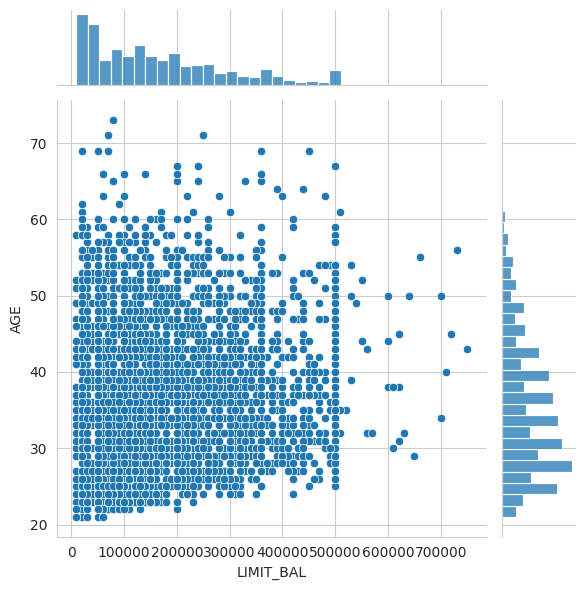

In [38]:
sns.jointplot(x='LIMIT_BAL',y='AGE',data=df,kind="scatter")
plt.show()

#Facet Grid

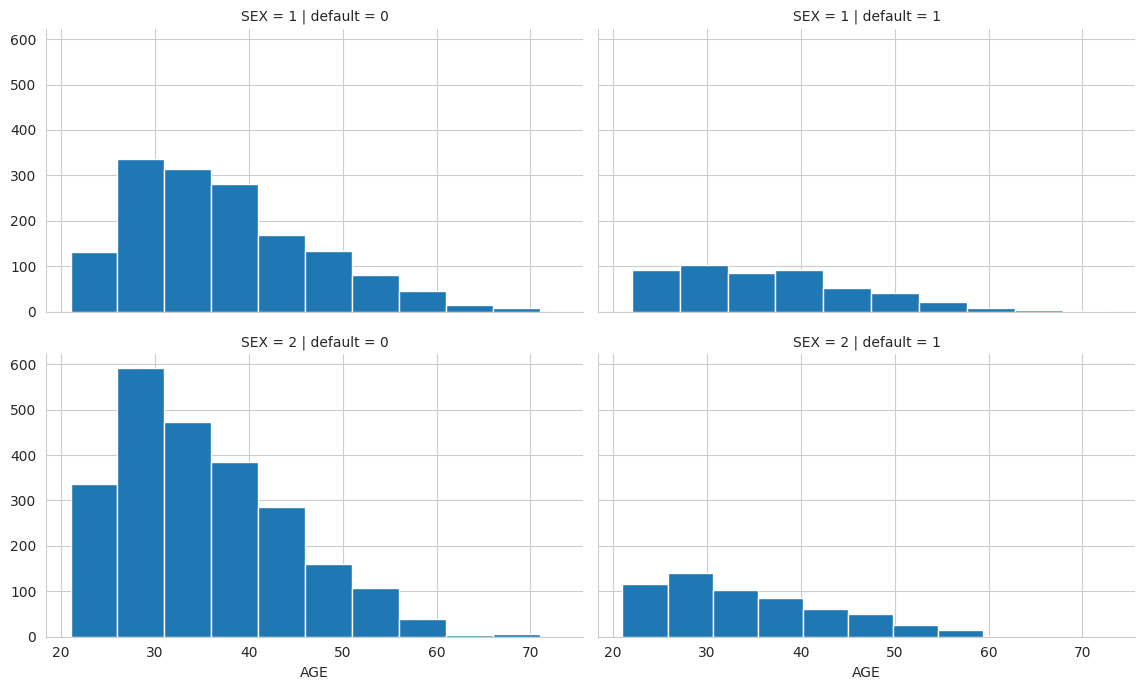

In [39]:
g = sns.FacetGrid(df, col = 'default', row = 'SEX', height=3.5, aspect=1.65)
g.map(plt.hist, 'AGE')
plt.show()

**From the above FaceGrid Plot we can see that NonDefaults have a higher proportion of people 30-40years**

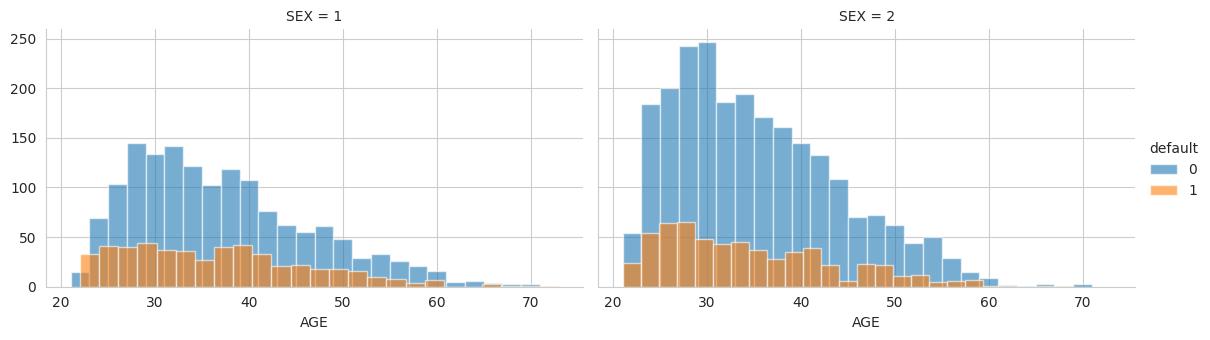

In [40]:
g = sns.FacetGrid(df, col='SEX', hue='default', height=3.5, aspect=1.65)
g.map(plt.hist, 'AGE', alpha=0.6, bins=25) #alpha is for opacity
g.add_legend()
plt.show()

**From the above FaceGrid Plot we can see that NonDefaults have a higher proportion of Female age between 30-40years**

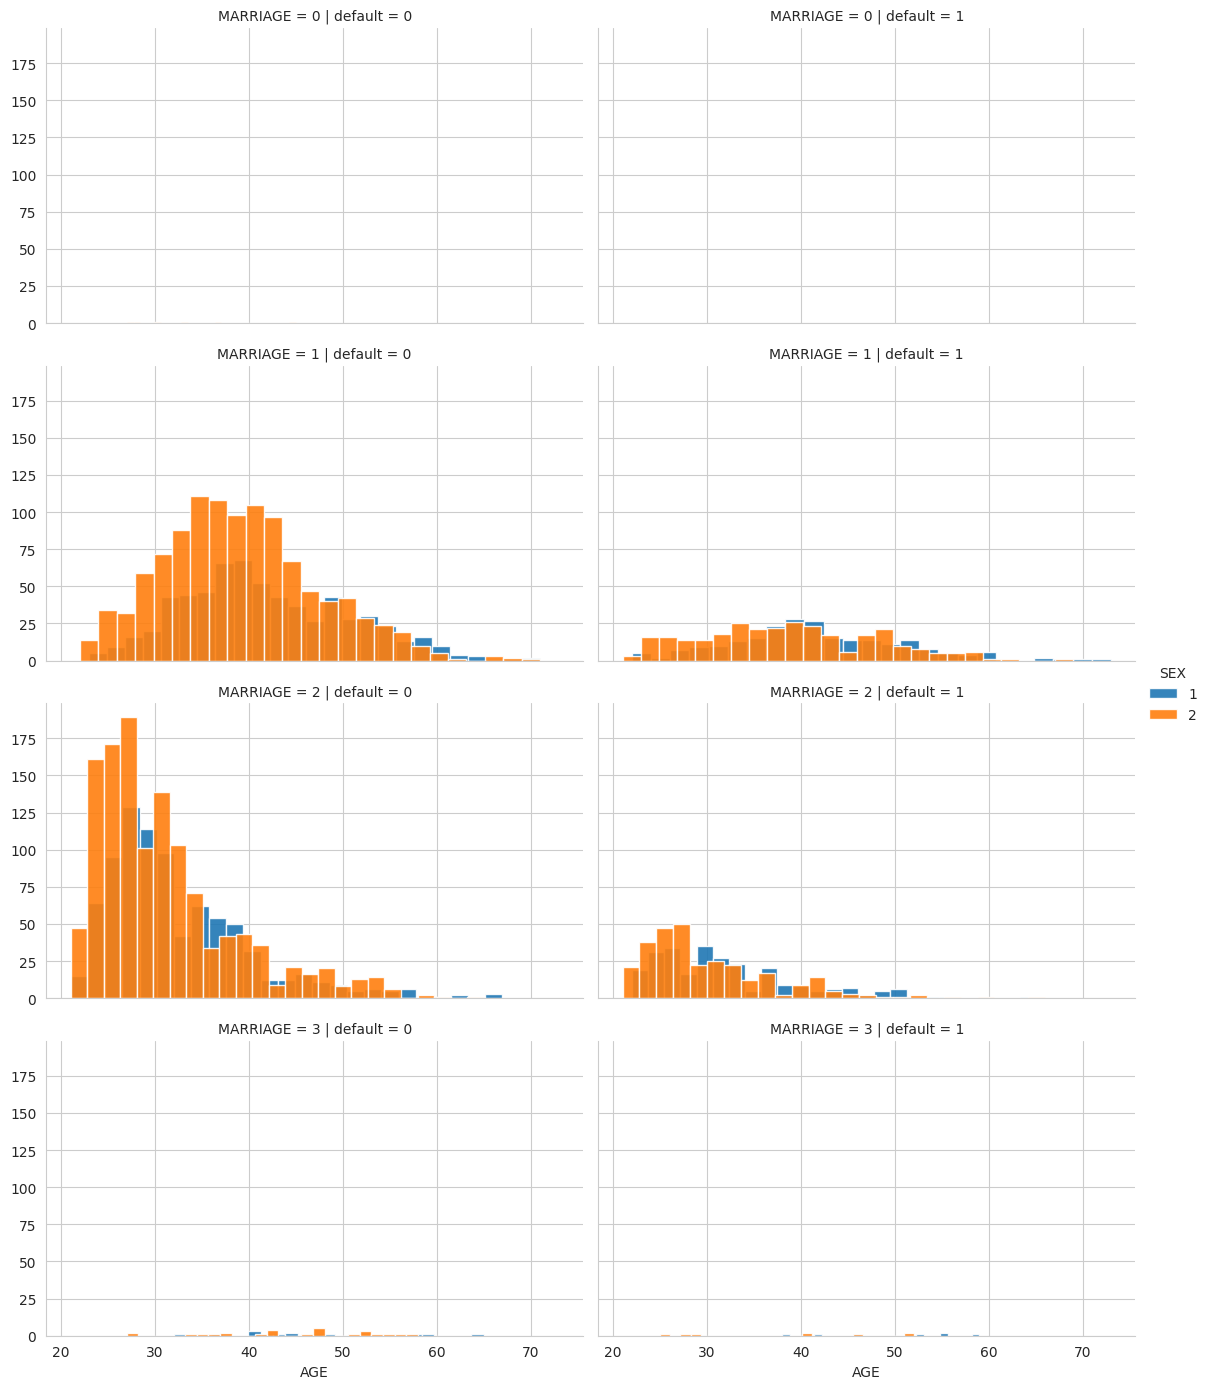

In [41]:
g = sns.FacetGrid(df, col='default', row= "MARRIAGE", hue='SEX', height=3.5, aspect=1.65)
g.map(plt.hist, 'AGE', alpha=0.9, bins=25)
g.add_legend()
plt.show()

#Step4: Data Cleaning
EDUCATION has category 5 and 6 that are unlabelled, moreover the category 0 is undocumented.

MARRIAGE has a label 0 that is undocumented

Data Transformation

The 0 in MARRIAGE can be safely categorized as 'Other' (thus 3).

The 0 (undocumented), 5 and 6 (label unknown) in EDUCATION can also be put in a 'Other' cathegory (thus 4)

Thus is a good occasion to learn how to use the .loc function

In [42]:
fil = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
df.loc[fil, 'EDUCATION'] = 4
df.EDUCATION.value_counts()

2    2336
1    1772
3     808
4      84
Name: EDUCATION, dtype: int64

In [43]:
df['EDUCATION'].value_counts(dropna = False)

2    2336
1    1772
3     808
4      84
Name: EDUCATION, dtype: int64

In [44]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

2    2649
1    2289
3      62
Name: MARRIAGE, dtype: int64

In [45]:
fil = (df.PAY_1 == -1) | (df.PAY_1==-2)
df.loc[fil,'PAY_1']=0
df.PAY_1.value_counts()
fil = (df.PAY_2 == -1) | (df.PAY_2==-2)
df.loc[fil,'PAY_2']=0
df.PAY_2.value_counts()
fil = (df.PAY_3 == -1) | (df.PAY_3==-2)
df.loc[fil,'PAY_3']=0
df.PAY_3.value_counts()
fil = (df.PAY_4 == -1) | (df.PAY_4==-2)
df.loc[fil,'PAY_4']=0
df.PAY_4.value_counts()
fil = (df.PAY_5 == -1) | (df.PAY_5==-2)
df.loc[fil,'PAY_5']=0
df.PAY_5.value_counts()
fil = (df.PAY_6 == -1) | (df.PAY_6==-2)
df.loc[fil,'PAY_6']=0
df.PAY_6.value_counts()

0    4482
2     463
3      26
4      12
7      11
5       4
6       2
Name: PAY_6, dtype: int64

In [46]:
df.head(2)

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
ID                                                                            
10748     310000    1          3         1   32      0      0      0      0   
12574      10000    2          3         1   49      0      0      0      0   

       PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
ID            ...                                                        
10748      0  ...      84373      57779      14163      8295      6000   
12574      2  ...       1690       1138        930         0         0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
ID                                                      
10748      4000      3000      1000      2000        0  
12574      2828         0       182         0        1  

[2 rows x 24 columns]

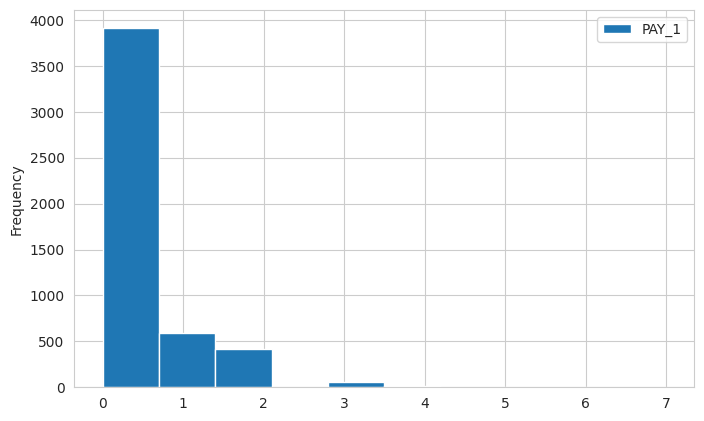

In [47]:
df.plot(y = 'PAY_1',kind='hist')
plt.legend()
plt.show()

In [48]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

PAY_AMT1      PAY_AMT2       PAY_AMT3      PAY_AMT4       PAY_AMT5  \
count    5000.0000  5.000000e+03    5000.000000    5000.00000    5000.000000   
mean     5712.7126  6.168286e+03    5847.442000    5219.85440    5081.839800   
std     15974.2450  2.945517e+04   19111.264928   16468.05314   16284.349383   
min         0.0000  0.000000e+00       0.000000       0.00000       0.000000   
25%      1000.0000  7.997500e+02     396.000000     316.00000     278.500000   
50%      2089.0000  2.011500e+03    1811.500000    1520.00000    1500.000000   
75%      5000.0000  5.000000e+03    5000.000000    4137.75000    4200.000000   
max    405016.0000  1.684259e+06  508229.000000  331788.00000  379267.000000   

            PAY_AMT6  
count    5000.000000  
mean     5716.655000  
std     20330.666372  
min         0.000000  
25%       169.250000  
50%      1490.000000  
75%      4000.000000  
max    528666.000000

In [49]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

BILL_AMT1      BILL_AMT2     BILL_AMT3      BILL_AMT4  \
count    5000.000000    5000.000000  5.000000e+03    5000.000000   
mean    51286.271400   49120.037800  4.711428e+04   43592.987800   
std     74472.533245   71714.254732  7.282651e+04   65300.378231   
min    -15308.000000  -33350.000000 -3.404100e+04  -81334.000000   
25%      3651.250000    2917.000000  2.778000e+03    2485.750000   
50%     22380.000000   20887.000000  1.984800e+04   19191.500000   
75%     66651.500000   64292.750000  5.909100e+04   52586.750000   
max    746814.000000  624475.000000  1.664089e+06  628699.000000   

           BILL_AMT5      BILL_AMT6  
count    5000.000000    5000.000000  
mean    40624.531600   39100.713400  
std     61031.613035   59561.490754  
min    -81334.000000  -73895.000000  
25%      1745.000000    1244.500000  
50%     18201.500000   17079.000000  
75%     50074.250000   48956.000000  
max    508213.000000  513798.000000

In [50]:
df.columns = df.columns.map(str.lower)

In [51]:
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

#Step5: Feature Scaling of Numerical Attributes

In [52]:
col_to_norm = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
       'pay_amt4', 'pay_amt5', 'pay_amt6']
df[col_to_norm] = df[col_to_norm].apply(lambda x : (x-np.mean(x))/np.std(x))

In [53]:
df.head()

limit_bal  sex  education  marriage       age  pay_1  pay_2  pay_3  \
ID                                                                          
10748   1.069816    1          3         1 -0.384536      0      0      0   
12574  -1.211339    2          3         1  1.448744      0      0      0   
29677  -0.907185    1          2         1 -0.815896      0      0      0   
8857   -0.679069    2          3         1  1.772264      2      2      3   
21099   0.765662    1          1         2 -0.168856      1      2      0   

       pay_4  pay_5  ...  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  \
ID                   ...                                                        
10748      0      0  ...   0.624561   0.281103  -0.418730  0.161669 -0.005714   
12574      0      2  ...  -0.641760  -0.647050  -0.640926 -0.357656 -0.209434   
29677      0      0  ...   0.036481  -0.644395   0.082046 -0.357656  1.361144   
8857       3      3  ...  -0.043572  -0.013249   0.025292 -0.126010 -0.155108   
21099      0      2  ...  -0.323843  -0.411869  -0.365335 -0.357656 -0.073620   

       pay_amt3  pay_amt4  pay_amt5  pay_amt6  default  
ID                                                      
10748 -0.096677 -0.134811 -0.250685 -0.182829        0  
12574 -0.158009 -0.317000 -0.300923 -0.281212        1  
29677 -0.190872 -0.238052  2.389353 -0.213032        0  
8857  -0.222270 -0.317000 -0.213836 -0.202505        1  
21099 -0.201338 -0.317000 -0.189271 -0.182829        0  

[5 rows x 24 columns]

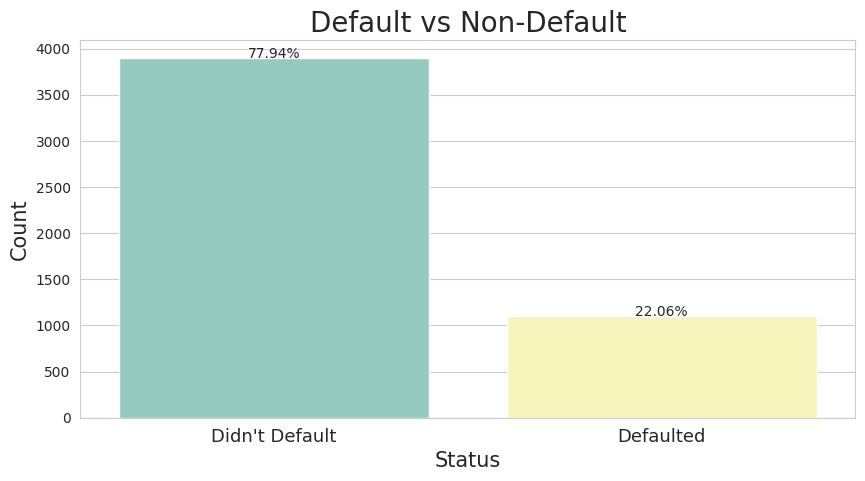

In [54]:
plt.figure(figsize = (10,5))
ax = sns.countplot(df['default'], palette='Set3')

ax.set_title('Default vs Non-Default',fontsize = 20)
ax.set_xlabel('Status',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Didn\'t Default','Defaulted'],fontsize = 13)

# adding percentage to the top of each bar
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f'{height/total * 100}%', ha="center") 
plt.show()

Percentage of Defaulters are smaller than the Non Defaulters in the given dataset

#Step6: Spiliting Dataset into training(88%) and test set(12%)

In [55]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.12,random_state = 1)

In [56]:
#Shape
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X: (5000, 23)
Shape of y: (5000,)
Shape of X_train: (4400, 23)
Shape of y_train: (4400,)
Shape of X_test: (600, 23)
Shape of y_test: (600,)


Random Undersampling:

In [57]:
#importing random under sampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
#resample
rus = RandomUnderSampler(random_state=1, replacement=True)
x_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

#print shape
print('Original dataset shape:', y_train.shape)
print('Resampled dataset shape:', y_train_rus.shape)

Original dataset shape: (4400,)
Resampled dataset shape: (1926,)


Class=Didn't Default, n=963 (50.0%)
Class=Default, n=963 (50.0%)


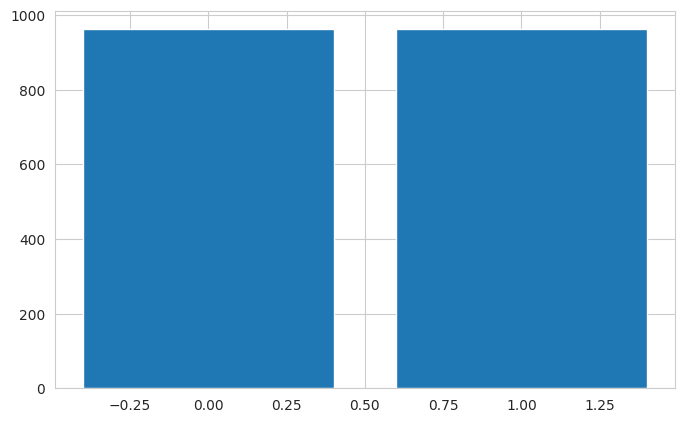

In [58]:
#visualization of resampled data
def resampled_data_visual(y_train_rus):
  dflt=["Didn\'t Default", "Default"]
  counter = Counter(y_train_rus)
  for key,value in counter.items():
    per = value / len(y_train_rus) * 100
    print(f'Class={dflt[key]}, n={value} ({per}%)')
  # plot the distribution
  plt.bar(counter.keys(), counter.values())
  plt.show()

resampled_data_visual(y_train_rus)

##***SMOTE:***

In [59]:
#SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()

# fit predictor and target variable
x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print('Original dataset shape:', y_train.shape)
print('Resampled dataset shape:', y_train_smote.shape)

Original dataset shape: (4400,)
Resampled dataset shape: (6874,)


Class=Didn't Default, n=3437 (50.0%)
Class=Default, n=3437 (50.0%)


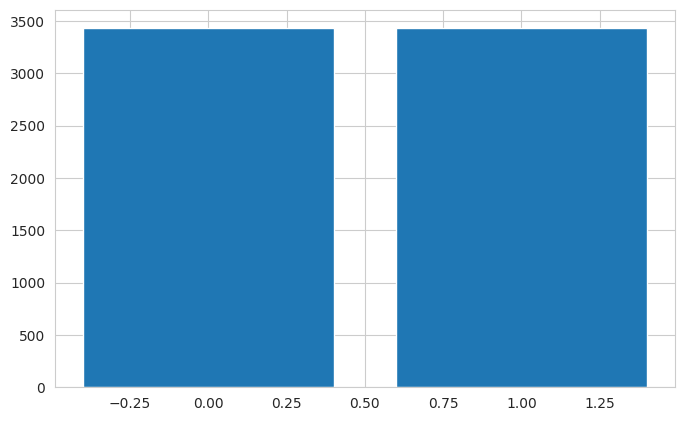

In [60]:
#visualization of resampled data
resampled_data_visual(y_train_smote)

In [61]:
#Columns needed to compare metrics
comparison_columns = ['Model_Name', 'Train_Accuracy', 'Train_Recall', 'Train_Precision', 'Train_F1score',
                      'Train_AUC' ,'Test_Accuracy', 'Test_Recall', 'Test_Precision','Test_F1score', 'Test_AUC']

In [62]:
#Function to evaluate the model
def model_evaluation(model_name_RUS,model_name_SMOTE,model_var_rus, model_var_smote, x_train_rus, y_train_rus, x_train_smote, y_train_smote):
  ''' This function predicts and evaluates various models for clasification for Random Undersampling and SMOTE algorithms, visualizes results 
      and creates a dataframe that compares the various models.'''
  
  #Making predictions random undersampling
  y_pred_rus_train = model_var_rus.predict(x_train_rus)
  y_pred_rus_test = model_var_rus.predict(X_test)
  
  #probs
  train_rus_proba = model_var_rus.predict_proba(x_train_rus)
  test_rus_proba = model_var_rus.predict_proba(X_test)

  #Making predictions smote
  y_pred_smote_train = model_var_smote.predict(x_train_smote)
  y_pred_smote_test = model_var_smote.predict(X_test)
  
  #probs
  train_sm_proba = model_var_smote.predict_proba(x_train_smote)
  test_sm_proba = model_var_smote.predict_proba(X_test)

  #Evaluation 
  #Accuracy RUS
  accuracy_rus_train = accuracy_score(y_train_rus,y_pred_rus_train)
  accuracy_rus_test = accuracy_score(y_test,y_pred_rus_test)

  #Accuracy SMOTE
  accuracy_smote_train = accuracy_score(y_train_smote,y_pred_smote_train)
  accuracy_smote_test = accuracy_score(y_test,y_pred_smote_test)

  #Confusion Matrix RUS
  cm_rus_train = confusion_matrix(y_train_rus,y_pred_rus_train)
  cm_rus_test = confusion_matrix(y_test,y_pred_rus_test)
  #Confusion Matrix SMOTE
  cm_smote_train = confusion_matrix(y_train_smote,y_pred_smote_train)
  cm_smote_test = confusion_matrix(y_test,y_pred_smote_test)

  #Recall RUS
  train_recall_rus = recall_score(y_train_rus,y_pred_rus_train, average='weighted')
  test_recall_rus = recall_score(y_test,y_pred_rus_test, average='weighted')
  #Recall SMOTE
  train_recall_smote = recall_score(y_train_smote,y_pred_smote_train, average='weighted')
  test_recall_smote = recall_score(y_test,y_pred_smote_test, average='weighted')

  #Precision RUS
  train_precision_rus = precision_score(y_train_rus,y_pred_rus_train, average='weighted')
  test_precision_rus = precision_score(y_test,y_pred_rus_test, average='weighted')
  #Precision SMOTE
  train_precision_smote = precision_score(y_train_smote,y_pred_smote_train, average='weighted')
  test_precision_smote = precision_score(y_test,y_pred_smote_test, average='weighted')

  #F1 Score RUS
  train_f1_rus = f1_score(y_train_rus,y_pred_rus_train, average='weighted')
  test_f1_rus = f1_score(y_test,y_pred_rus_test, average='weighted')
  #F1 Score SMOTE
  train_f1_smote = f1_score(y_train_smote,y_pred_smote_train, average='weighted')
  test_f1_smote = f1_score(y_test,y_pred_smote_test, average='weighted')

  #ROC-AUC RUS
  train_auc_rus = roc_auc_score(y_train_rus,train_rus_proba[:,1],average='weighted',multi_class = 'ovr')
  test_auc_rus = roc_auc_score(y_test,test_rus_proba[:,1],average='weighted',multi_class = 'ovr')
  
  #ROC-AUC SMOTE
  train_auc_smote = roc_auc_score(y_train_smote,train_sm_proba[:,1],average='weighted',multi_class = 'ovr')
  test_auc_smote = roc_auc_score(y_test,test_sm_proba[:,1],average='weighted',multi_class = 'ovr')


  #Visualising Results RUS
  print(6*'-', "Evaluation on Random Undersampled data -----", 6*'-' + str(model_name_RUS) + "------")
  print()
  print(25*'-',"Test data",25*'-')
  print()
  print("Confusion matrix \n")
  plt.figure(figsize=(3,2))
  sns.heatmap(cm_rus_test,annot= True,linewidths=1,cmap='coolwarm', fmt="2.2f")
  plt.show()
  print()
  print(classification_report(y_test,y_pred_rus_test))

  #create ROC curve
  fpr = {}
  tpr = {}
  thresh ={}
  no_of_class=2
  for i in range(no_of_class):   
      fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, test_rus_proba[:,i], pos_label=i)
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0 vs Others '+"AUC= "+str(test_auc_rus))
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Others '+"AUC= "+str(test_auc_rus))
  plt.title('Multiclass ROC curve of ' + str(model_name_RUS))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()

  #Visualising Results SMOTE
  print()
  print()
  print(6*'-','Evaluation on SMOTE data',6*'-' + str(model_name_SMOTE) + '-----')
  print()
  print(25*'-',"Test data",25*'-')
  print()
  print("Confusion matrix \n")
  plt.figure(figsize=(3,2))
  sns.heatmap(cm_smote_test,annot= True,linewidths=1,cmap='coolwarm', fmt="2.2f")
  plt.show()
  print()
  print(classification_report(y_test,y_pred_smote_test))

  #create ROC curve
  fpr = {}
  tpr = {}
  thresh ={}
  no_of_class=2
  for i in range(no_of_class):    
      fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, test_sm_proba[:,i], pos_label=i)
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0 vs Others'+" AUC= "+str(test_auc_smote))
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Others '+"AUC= "+str(test_auc_smote))
  plt.title('Multiclass ROC curve of '+ str(model_name_SMOTE))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()

  #Saving our results
  print()
  global comparison_columns
  metric_scores_rus = [model_name_RUS,accuracy_rus_train,train_recall_rus,train_precision_rus,train_f1_rus,train_auc_rus,accuracy_rus_test,test_recall_rus,test_precision_rus,test_f1_rus,test_auc_rus]
  final_dict_rus = dict(zip(comparison_columns,metric_scores_rus))

  metric_scores_smote = [model_name_SMOTE,accuracy_smote_train,train_recall_smote,train_precision_smote,train_f1_smote,train_auc_smote,accuracy_smote_test,test_recall_smote,test_precision_smote,test_f1_smote,test_auc_smote]
  final_dict_smote = dict(zip(comparison_columns,metric_scores_smote))

  dict_list = [final_dict_rus, final_dict_smote]
  return dict_list

In [63]:
#function to create the comparison table
final_list = []
def add_list_to_final_df(dict_list):
  global final_list
  for elem in dict_list:
    final_list.append(elem)
  global comparison_df
  comparison_df = pd.DataFrame(final_list, columns= comparison_columns)

#Step7: Applying Machine Learning Algorithm for Classification Problem

#Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression
logistic_rus = LogisticRegression(class_weight='balanced',multi_class='multinomial', solver='lbfgs')
#fitting Undersampling
logistic_rus.fit(x_train_rus, y_train_rus)

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [65]:
#fitting on smote
logistic_smote = LogisticRegression(class_weight='balanced',multi_class='multinomial', solver='lbfgs')
logistic_smote.fit(x_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced', multi_class='multinomial')

------ Evaluation on Random Undersampled data ----- ------LogisticReg RUS------

------------------------- Test data -------------------------

Confusion matrix 



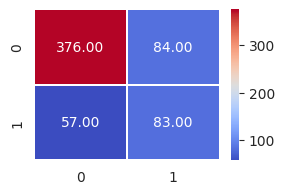


              precision    recall  f1-score   support

           0       0.87      0.82      0.84       460
           1       0.50      0.59      0.54       140

    accuracy                           0.77       600
   macro avg       0.68      0.71      0.69       600
weighted avg       0.78      0.77      0.77       600



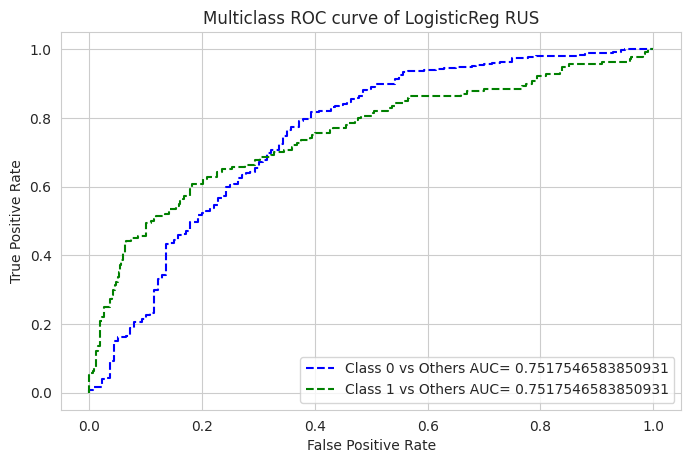



------ Evaluation on SMOTE data ------LogisticReg SMOTE-----

------------------------- Test data -------------------------

Confusion matrix 



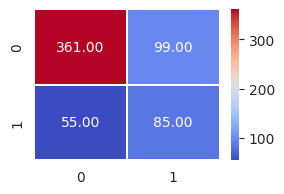


              precision    recall  f1-score   support

           0       0.87      0.78      0.82       460
           1       0.46      0.61      0.52       140

    accuracy                           0.74       600
   macro avg       0.66      0.70      0.67       600
weighted avg       0.77      0.74      0.75       600



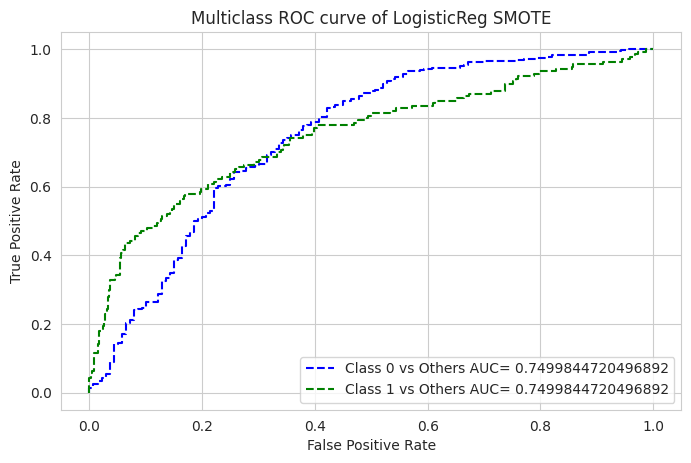

[{'Model_Name': 'LogisticReg RUS',
  'Train_Accuracy': 0.7159916926272066,
  'Train_Recall': 0.7159916926272066,
  'Train_Precision': 0.7286993058092802,
  'Train_F1score': 0.711990906374532,
  'Train_AUC': 0.7839339033329775,
  'Test_Accuracy': 0.765,
  'Test_Recall': 0.765,
  'Test_Precision': 0.7817109430100538,
  'Test_F1score': 0.7717812446425512,
  'Test_AUC': 0.7517546583850931},
 {'Model_Name': 'LogisticReg SMOTE',
  'Train_Accuracy': 0.7103578702356707,
  'Train_Recall': 0.7103578702356707,
  'Train_Precision': 0.7190063350043361,
  'Train_F1score': 0.707469898667291,
  'Train_AUC': 0.7769232273444551,
  'Test_Accuracy': 0.7433333333333333,
  'Test_Recall': 0.7433333333333333,
  'Test_Precision': 0.773094342251951,
  'Test_F1score': 0.7543153503579683,
  'Test_AUC': 0.7499844720496892}]

In [66]:
#Let's evaluate logistic reg
logistic_reg_list = model_evaluation('LogisticReg RUS','LogisticReg SMOTE',logistic_rus, logistic_smote, x_train_rus, y_train_rus, x_train_smote, y_train_smote)
logistic_reg_list

In [67]:
#adding result to final list
add_list_to_final_df(logistic_reg_list)

#Stochastic Gradient Descent

In [68]:
from sklearn.linear_model import SGDClassifier
sgd_rus = SGDClassifier(loss='log', penalty='l1', learning_rate='optimal',random_state=1)
sgd_rus.fit(x_train_rus,y_train_rus)

SGDClassifier(loss='log', penalty='l1', random_state=1)

In [69]:
#Classifier SMOTE
sgd_smote = SGDClassifier(loss='log', penalty='l1', learning_rate='optimal',random_state=1)
sgd_smote.fit(x_train_smote,y_train_smote)

SGDClassifier(loss='log', penalty='l1', random_state=1)

------ Evaluation on Random Undersampled data ----- ------Stochastic Gradient Descent RUS------

------------------------- Test data -------------------------

Confusion matrix 



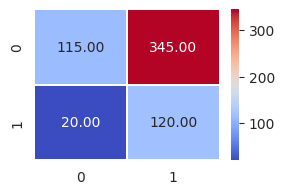


              precision    recall  f1-score   support

           0       0.85      0.25      0.39       460
           1       0.26      0.86      0.40       140

    accuracy                           0.39       600
   macro avg       0.55      0.55      0.39       600
weighted avg       0.71      0.39      0.39       600



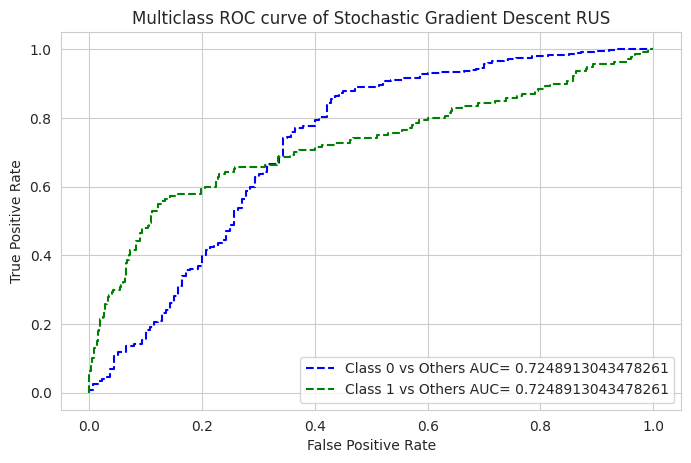



------ Evaluation on SMOTE data ------Stochastic Gradient Descent SMOTE-----

------------------------- Test data -------------------------

Confusion matrix 



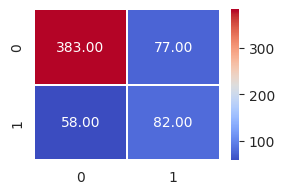


              precision    recall  f1-score   support

           0       0.87      0.83      0.85       460
           1       0.52      0.59      0.55       140

    accuracy                           0.78       600
   macro avg       0.69      0.71      0.70       600
weighted avg       0.79      0.78      0.78       600



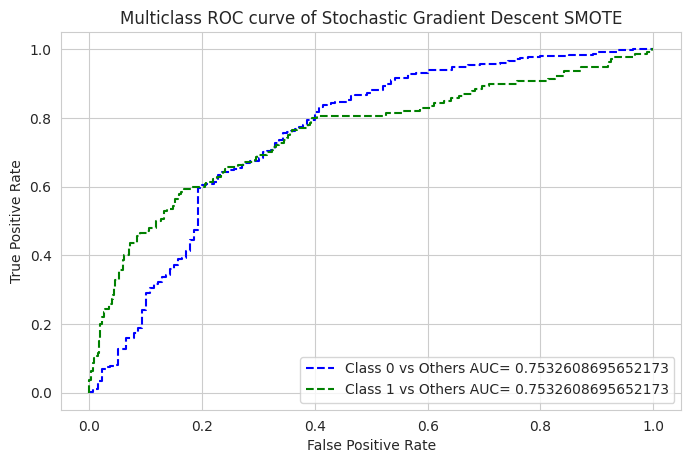

[{'Model_Name': 'Stochastic Gradient Descent RUS',
  'Train_Accuracy': 0.5934579439252337,
  'Train_Recall': 0.5934579439252337,
  'Train_Precision': 0.6645591250854409,
  'Train_F1score': 0.544226328258664,
  'Train_AUC': 0.7511594629537973,
  'Test_Accuracy': 0.39166666666666666,
  'Test_Recall': 0.39166666666666666,
  'Test_Precision': 0.7133014735165273,
  'Test_F1score': 0.3889205268884413,
  'Test_AUC': 0.7248913043478261},
 {'Model_Name': 'Stochastic Gradient Descent SMOTE',
  'Train_Accuracy': 0.7009019493744545,
  'Train_Recall': 0.7009019493744545,
  'Train_Precision': 0.7149275702912992,
  'Train_F1score': 0.6959414291330098,
  'Train_AUC': 0.7709287563524463,
  'Test_Accuracy': 0.775,
  'Test_Recall': 0.775,
  'Test_Precision': 0.7861706527474721,
  'Test_F1score': 0.7797764653914826,
  'Test_AUC': 0.7532608695652173}]

In [70]:
sgd_eval_list = model_evaluation('Stochastic Gradient Descent RUS', 'Stochastic Gradient Descent SMOTE', sgd_rus, sgd_smote, x_train_rus, y_train_rus, x_train_smote, y_train_smote)
sgd_eval_list

In [71]:
#adding result to final list
add_list_to_final_df(sgd_eval_list)

#K-Nearest Neighbour

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
# creating KNN model
knn_model = KNeighborsClassifier(n_jobs=-1)

# finding the best parameters for knn_model by gridsearchcv
param_dict={'n_neighbors':[3,5,7,9,11,13,15,21,23,25]}
knn_grid_rus= GridSearchCV(knn_model, param_grid=param_dict, cv = 4)

In [74]:
#Fitting RUS to grid search
knn_grid_rus.fit(x_train_rus,y_train_rus)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 21, 23, 25]})

In [75]:
#optimal model
knn_tuned_rus = knn_grid_rus.best_estimator_

In [76]:
#Fitting SMOTE
param_dict={'n_neighbors':[3,5,7,9,11,13,15,21,23,25]}
knn_grid_search_smote = GridSearchCV(knn_model, param_grid=param_dict, cv = 4)

In [77]:
knn_grid_search_smote.fit(x_train_smote,y_train_smote)
#optimal smote model
knn_tuned_smote = knn_grid_search_smote.best_estimator_

------ Evaluation on Random Undersampled data ----- ------KNN Tuned RUS------

------------------------- Test data -------------------------

Confusion matrix 



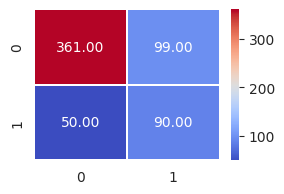


              precision    recall  f1-score   support

           0       0.88      0.78      0.83       460
           1       0.48      0.64      0.55       140

    accuracy                           0.75       600
   macro avg       0.68      0.71      0.69       600
weighted avg       0.78      0.75      0.76       600



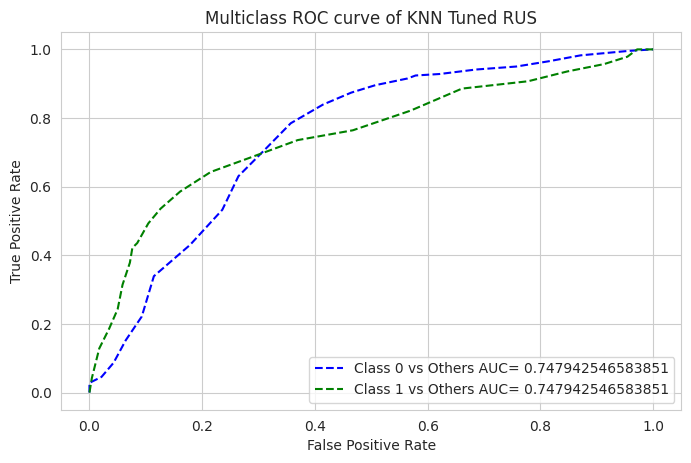



------ Evaluation on SMOTE data ------KNN Tuned SMOTE-----

------------------------- Test data -------------------------

Confusion matrix 



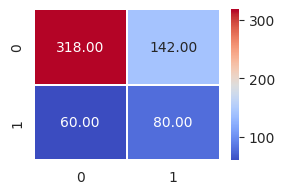


              precision    recall  f1-score   support

           0       0.84      0.69      0.76       460
           1       0.36      0.57      0.44       140

    accuracy                           0.66       600
   macro avg       0.60      0.63      0.60       600
weighted avg       0.73      0.66      0.68       600



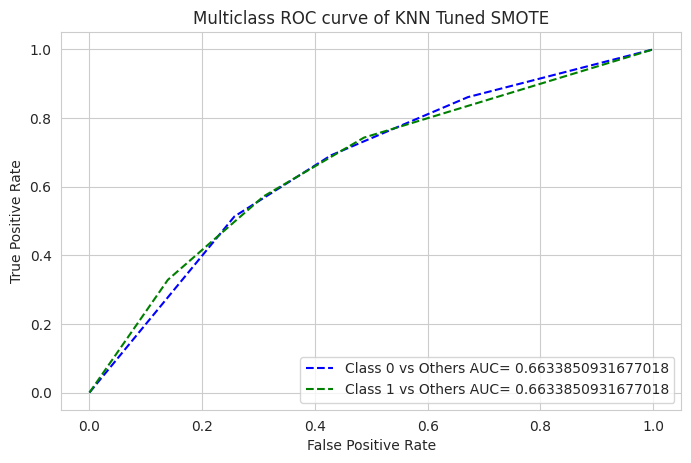

[{'Model_Name': 'KNN Tuned RUS',
  'Train_Accuracy': 0.7336448598130841,
  'Train_Recall': 0.7336448598130841,
  'Train_Precision': 0.7461432725950834,
  'Train_F1score': 0.7302202088419383,
  'Train_AUC': 0.8020000668558039,
  'Test_Accuracy': 0.7516666666666667,
  'Test_Recall': 0.7516666666666667,
  'Test_Precision': 0.7845093268450932,
  'Test_F1score': 0.7631743084902818,
  'Test_AUC': 0.747942546583851},
 {'Model_Name': 'KNN Tuned SMOTE',
  'Train_Accuracy': 0.9061681699156241,
  'Train_Recall': 0.9061681699156241,
  'Train_Precision': 0.9172042090735628,
  'Train_F1score': 0.9055435205332323,
  'Train_AUC': 0.9877693744900202,
  'Test_Accuracy': 0.6633333333333333,
  'Test_Recall': 0.6633333333333333,
  'Test_Precision': 0.729057629057629,
  'Test_F1score': 0.6849923302434544,
  'Test_AUC': 0.6633850931677018}]

In [78]:
#Model Evaluation for Random Forest Hyperparameter 
KNN_tuned_list = model_evaluation('KNN Tuned RUS', 'KNN Tuned SMOTE', knn_tuned_rus, knn_tuned_smote,x_train_rus, y_train_rus, x_train_smote, y_train_smote)
KNN_tuned_list

In [79]:
#adding list
add_list_to_final_df(KNN_tuned_list)

#Gaussian Naive Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB
#RUS
naive_bayes_rus = GaussianNB()
naive_bayes_rus.fit(x_train_rus,y_train_rus)

GaussianNB()

In [81]:
#SMOTE
naive_bayes_smote = GaussianNB()
naive_bayes_smote.fit(x_train_smote,y_train_smote)

GaussianNB()

------ Evaluation on Random Undersampled data ----- ------Gaussian Naive Bayes RUS------

------------------------- Test data -------------------------

Confusion matrix 



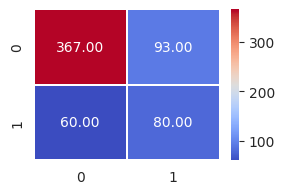


              precision    recall  f1-score   support

           0       0.86      0.80      0.83       460
           1       0.46      0.57      0.51       140

    accuracy                           0.74       600
   macro avg       0.66      0.68      0.67       600
weighted avg       0.77      0.74      0.75       600



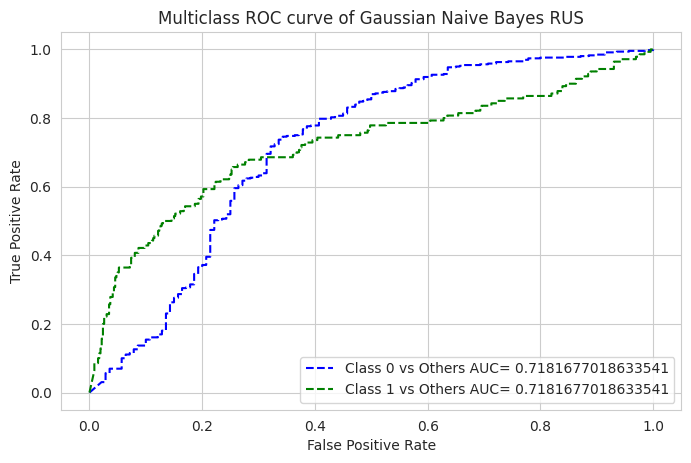



------ Evaluation on SMOTE data ------Gaussian Naive Bayes SMOTE-----

------------------------- Test data -------------------------

Confusion matrix 



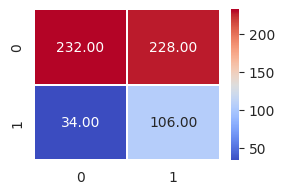


              precision    recall  f1-score   support

           0       0.87      0.50      0.64       460
           1       0.32      0.76      0.45       140

    accuracy                           0.56       600
   macro avg       0.59      0.63      0.54       600
weighted avg       0.74      0.56      0.59       600



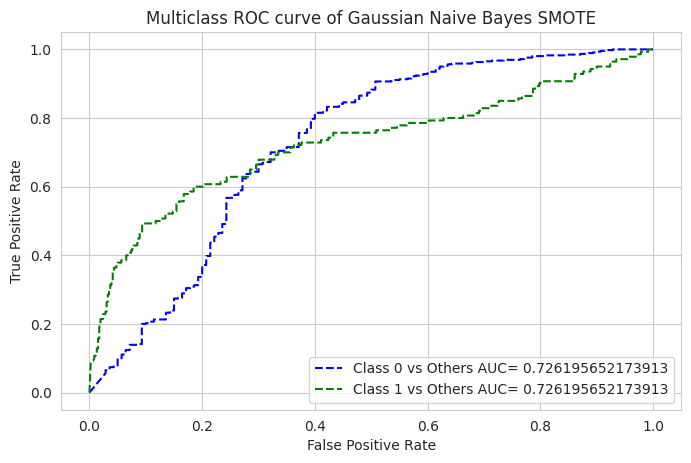

[{'Model_Name': 'Gaussian Naive Bayes RUS',
  'Train_Accuracy': 0.6869158878504673,
  'Train_Recall': 0.6869158878504673,
  'Train_Precision': 0.7014906635917274,
  'Train_F1score': 0.6811499027425637,
  'Train_AUC': 0.7504801217206958,
  'Test_Accuracy': 0.745,
  'Test_Recall': 0.745,
  'Test_Precision': 0.7668381367519053,
  'Test_F1score': 0.7536989745381458,
  'Test_AUC': 0.7181677018633541},
 {'Model_Name': 'Gaussian Naive Bayes SMOTE',
  'Train_Accuracy': 0.6534768693628165,
  'Train_Recall': 0.6534768693628165,
  'Train_Precision': 0.668880189837013,
  'Train_F1score': 0.645391025059063,
  'Train_AUC': 0.7472211262045976,
  'Test_Accuracy': 0.5633333333333334,
  'Test_Recall': 0.5633333333333334,
  'Test_Precision': 0.7427235754055799,
  'Test_F1score': 0.594350873522335,
  'Test_AUC': 0.726195652173913}]

In [82]:
#Random Forest Evaluation
naive_bayes_eval_list = model_evaluation('Gaussian Naive Bayes RUS', 'Gaussian Naive Bayes SMOTE', naive_bayes_rus, naive_bayes_smote, x_train_rus, y_train_rus, x_train_smote, y_train_smote)
naive_bayes_eval_list

In [83]:
#adding list
add_list_to_final_df(naive_bayes_eval_list)

#Decision Tree Classification

In [84]:
from sklearn.tree import DecisionTreeClassifier
#Classifier RUS
dt_rus = DecisionTreeClassifier(criterion = 'entropy',random_state = 0)
dt_rus.fit(x_train_rus,y_train_rus)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [85]:
#Classifier SMOTE
dt_smote = DecisionTreeClassifier()
dt_smote.fit(x_train_smote,y_train_smote)

DecisionTreeClassifier()

------ Evaluation on Random Undersampled data ----- ------Decision Tree RUS------

------------------------- Test data -------------------------

Confusion matrix 



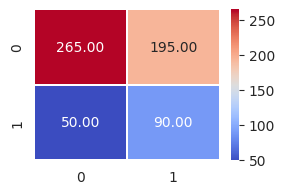


              precision    recall  f1-score   support

           0       0.84      0.58      0.68       460
           1       0.32      0.64      0.42       140

    accuracy                           0.59       600
   macro avg       0.58      0.61      0.55       600
weighted avg       0.72      0.59      0.62       600



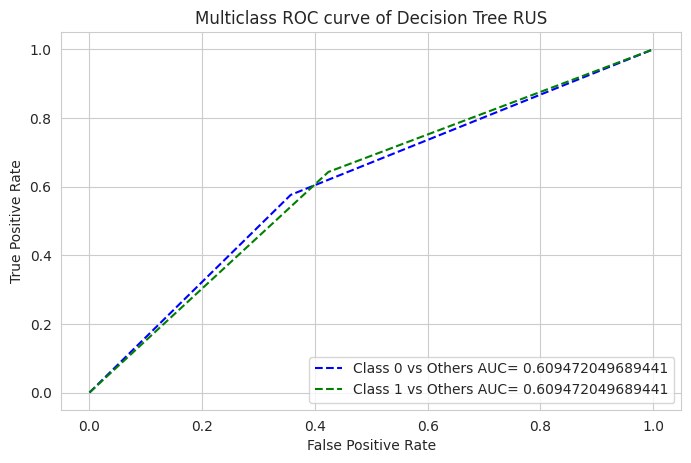



------ Evaluation on SMOTE data ------Decision Tree SMOTE-----

------------------------- Test data -------------------------

Confusion matrix 



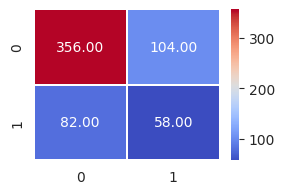


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       460
           1       0.36      0.41      0.38       140

    accuracy                           0.69       600
   macro avg       0.59      0.59      0.59       600
weighted avg       0.71      0.69      0.70       600



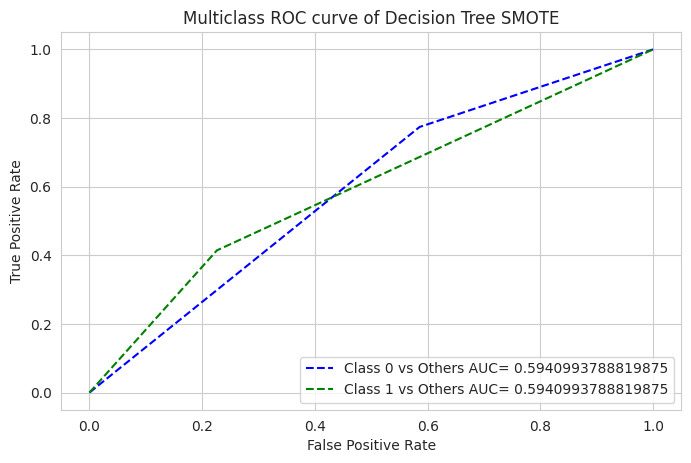

[{'Model_Name': 'Decision Tree RUS',
  'Train_Accuracy': 1.0,
  'Train_Recall': 1.0,
  'Train_Precision': 1.0,
  'Train_F1score': 1.0,
  'Train_AUC': 1.0,
  'Test_Accuracy': 0.5916666666666667,
  'Test_Recall': 0.5916666666666667,
  'Test_Precision': 0.7186577554998608,
  'Test_F1score': 0.623124604680582,
  'Test_AUC': 0.609472049689441},
 {'Model_Name': 'Decision Tree SMOTE',
  'Train_Accuracy': 1.0,
  'Train_Recall': 1.0,
  'Train_Precision': 1.0,
  'Train_F1score': 1.0,
  'Train_AUC': 1.0,
  'Test_Accuracy': 0.69,
  'Test_Recall': 0.69,
  'Test_Precision': 0.7066745588815603,
  'Test_F1score': 0.6974940633342674,
  'Test_AUC': 0.5940993788819875}]

In [86]:
dt_eval_list = model_evaluation('Decision Tree RUS', 'Decision Tree SMOTE', dt_rus, dt_smote, x_train_rus, y_train_rus, x_train_smote, y_train_smote)
dt_eval_list

In [87]:
#adding list
add_list_to_final_df(dt_eval_list)

#Random Forest Classification

In [88]:
from sklearn.ensemble import RandomForestClassifier
#RUS
rf_rus = RandomForestClassifier(random_state=0, criterion = 'entropy', max_depth=5, n_estimators=100)
rf_rus.fit(x_train_rus,y_train_rus)

RandomForestClassifier(criterion='entropy', max_depth=5, random_state=0)

In [89]:
#SMOTE
rf_smote = RandomForestClassifier(random_state=0, max_depth=5, n_estimators=100, oob_score=True)
rf_smote.fit(x_train_smote,y_train_smote)

RandomForestClassifier(max_depth=5, oob_score=True, random_state=0)

------ Evaluation on Random Undersampled data ----- ------Random Forest RUS------

------------------------- Test data -------------------------

Confusion matrix 



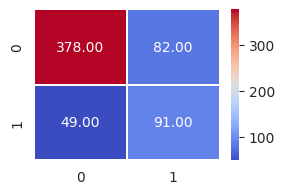


              precision    recall  f1-score   support

           0       0.89      0.82      0.85       460
           1       0.53      0.65      0.58       140

    accuracy                           0.78       600
   macro avg       0.71      0.74      0.72       600
weighted avg       0.80      0.78      0.79       600



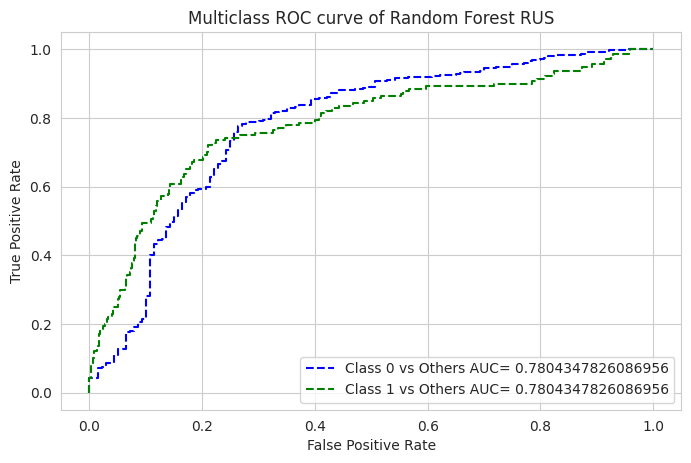



------ Evaluation on SMOTE data ------Random Forest SMOTE-----

------------------------- Test data -------------------------

Confusion matrix 



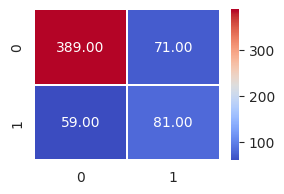


              precision    recall  f1-score   support

           0       0.87      0.85      0.86       460
           1       0.53      0.58      0.55       140

    accuracy                           0.78       600
   macro avg       0.70      0.71      0.71       600
weighted avg       0.79      0.78      0.79       600



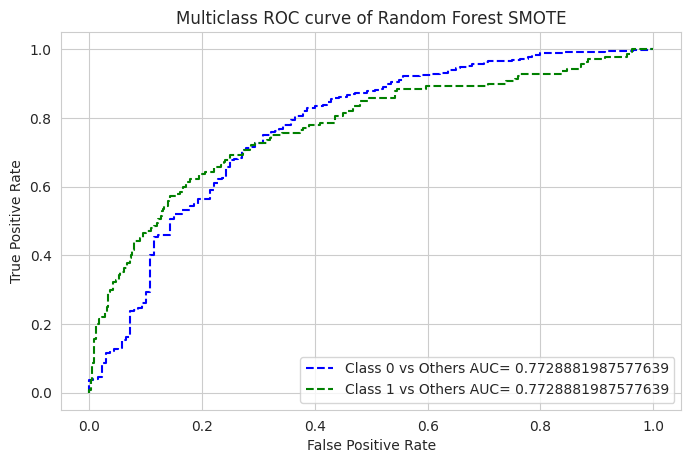

[{'Model_Name': 'Random Forest RUS',
  'Train_Accuracy': 0.7518172377985463,
  'Train_Recall': 0.7518172377985463,
  'Train_Precision': 0.7638928596854225,
  'Train_F1score': 0.7489451983070814,
  'Train_AUC': 0.8424774819947616,
  'Test_Accuracy': 0.7816666666666666,
  'Test_Recall': 0.7816666666666666,
  'Test_Precision': 0.8014245554186803,
  'Test_F1score': 0.7891148082646872,
  'Test_AUC': 0.7804347826086956},
 {'Model_Name': 'Random Forest SMOTE',
  'Train_Accuracy': 0.7566191446028513,
  'Train_Recall': 0.7566191446028513,
  'Train_Precision': 0.7641144658594453,
  'Train_F1score': 0.7548800761179911,
  'Train_AUC': 0.8426544165145953,
  'Test_Accuracy': 0.7833333333333333,
  'Test_Recall': 0.7833333333333333,
  'Test_Precision': 0.7900415100250626,
  'Test_F1score': 0.7863536700661797,
  'Test_AUC': 0.7728881987577639}]

In [90]:
#Random Forest Evaluation
rf_eval_list = model_evaluation('Random Forest RUS', 'Random Forest SMOTE', rf_rus, rf_smote, x_train_rus, y_train_rus, x_train_smote, y_train_smote)
rf_eval_list

In [91]:
#adding list
add_list_to_final_df(rf_eval_list)

###Random Forest Hyperparameter Tuning:

In [92]:
#classifier
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

#Parameter dictionary
params = {'max_depth': [3,5,10,20],'min_samples_leaf': [5,10,20,50,100],'n_estimators': [10,25,30,50,100,200]}

#Grid Search to get the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="f1_weighted")

In [93]:
#Fitting RUS to grid search
grid_search.fit(x_train_rus,y_train_rus)

#optimal model
rf_tuned_rus = grid_search.best_estimator_

Fitting 4 folds for each of 120 candidates, totalling 480 fits


In [94]:
#Fitting SMOTE
grid_search_smote = GridSearchCV(estimator=rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="f1_weighted")
grid_search_smote.fit(x_train_smote,y_train_smote)
#optimal smote model
rf_tuned_smote = grid_search_smote.best_estimator_

Fitting 4 folds for each of 120 candidates, totalling 480 fits


------ Evaluation on Random Undersampled data ----- ------RandomF Tuned RUS------

------------------------- Test data -------------------------

Confusion matrix 



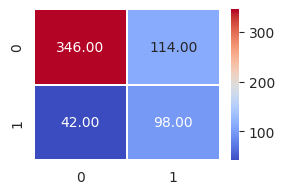


              precision    recall  f1-score   support

           0       0.89      0.75      0.82       460
           1       0.46      0.70      0.56       140

    accuracy                           0.74       600
   macro avg       0.68      0.73      0.69       600
weighted avg       0.79      0.74      0.76       600



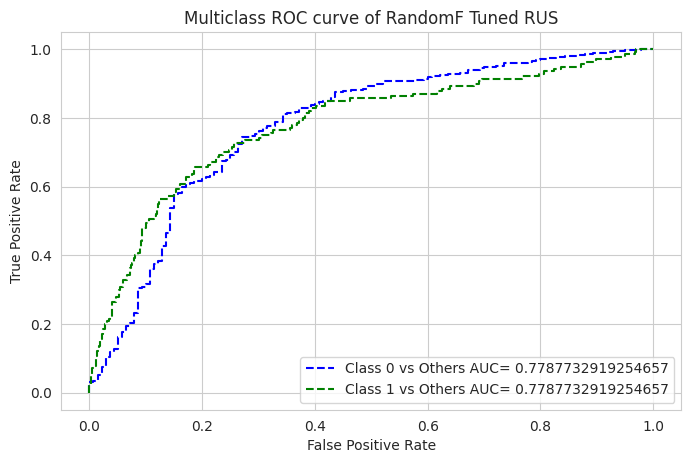



------ Evaluation on SMOTE data ------RandomF Tuned SMOTE-----

------------------------- Test data -------------------------

Confusion matrix 



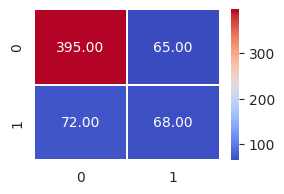


              precision    recall  f1-score   support

           0       0.85      0.86      0.85       460
           1       0.51      0.49      0.50       140

    accuracy                           0.77       600
   macro avg       0.68      0.67      0.68       600
weighted avg       0.77      0.77      0.77       600



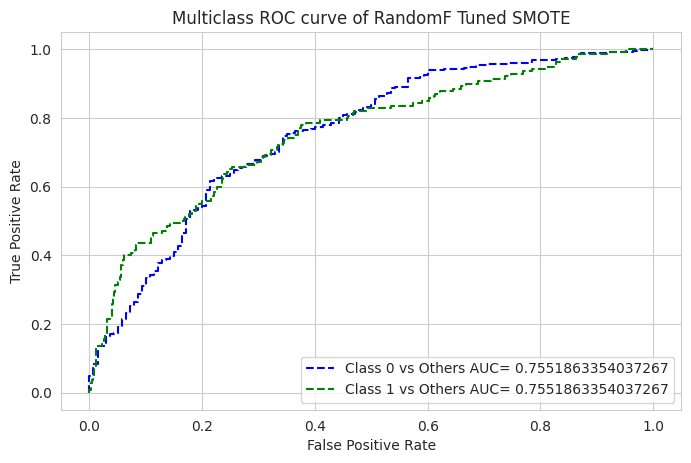

[{'Model_Name': 'RandomF Tuned RUS',
  'Train_Accuracy': 0.8302180685358256,
  'Train_Recall': 0.8302180685358256,
  'Train_Precision': 0.8314622551651283,
  'Train_F1score': 0.8300585942506669,
  'Train_AUC': 0.9188154876861314,
  'Test_Accuracy': 0.74,
  'Test_Recall': 0.74,
  'Test_Precision': 0.791538611165143,
  'Test_F1score': 0.7555531732418524,
  'Test_AUC': 0.7787732919254657},
 {'Model_Name': 'RandomF Tuned SMOTE',
  'Train_Accuracy': 0.9559208612161769,
  'Train_Recall': 0.9559208612161769,
  'Train_Precision': 0.9559273838548016,
  'Train_F1score': 0.9559207035631538,
  'Train_AUC': 0.9926263245082587,
  'Test_Accuracy': 0.7716666666666666,
  'Test_Recall': 0.7716666666666666,
  'Test_Precision': 0.7677636274841279,
  'Test_F1score': 0.769601416203358,
  'Test_AUC': 0.7551863354037267}]

In [95]:
#Model Evaluation for Random Forest Hyperparameter 
rf_tuned_list = model_evaluation('RandomF Tuned RUS', 'RandomF Tuned SMOTE', rf_tuned_rus, rf_tuned_smote,x_train_rus, y_train_rus, x_train_smote, y_train_smote)
rf_tuned_list

In [96]:
#adding list
add_list_to_final_df(rf_tuned_list)

Random Forest HyperParameter Tuned Feature Importance:

[]

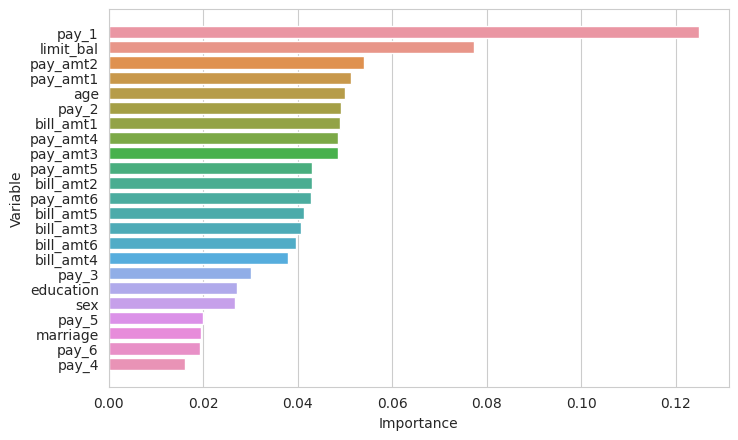

In [97]:
#visualisation
feature_imp = pd.DataFrame({"Variable": df.columns[:-1],"Importance": rf_tuned_smote.feature_importances_})
feature_imp.sort_values(by="Importance", ascending=False, inplace = True)
sns.barplot(x=feature_imp['Importance'],y= feature_imp['Variable'])
plt.plot()

#XGBOOST classifier

In [98]:
from xgboost import XGBClassifier
#fitting rus
xgb_rus = XGBClassifier(n_estimators=100,max_depth=12,min_samples_leaf=20,min_samples_split=30)
xgb_rus.fit(x_train_rus,y_train_rus)

XGBClassifier(max_depth=12, min_samples_leaf=20, min_samples_split=30)

In [99]:
#fitting smote
xgb_smote = XGBClassifier(n_estimators=100,max_depth=12,min_samples_leaf=20,min_samples_split=30)
xgb_smote.fit(x_train_smote,y_train_smote)

XGBClassifier(max_depth=12, min_samples_leaf=20, min_samples_split=30)

------ Evaluation on Random Undersampled data ----- ------XGB RUS------

------------------------- Test data -------------------------

Confusion matrix 



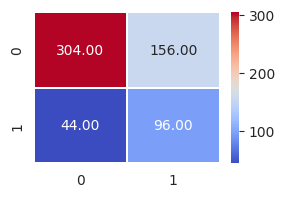


              precision    recall  f1-score   support

           0       0.87      0.66      0.75       460
           1       0.38      0.69      0.49       140

    accuracy                           0.67       600
   macro avg       0.63      0.67      0.62       600
weighted avg       0.76      0.67      0.69       600



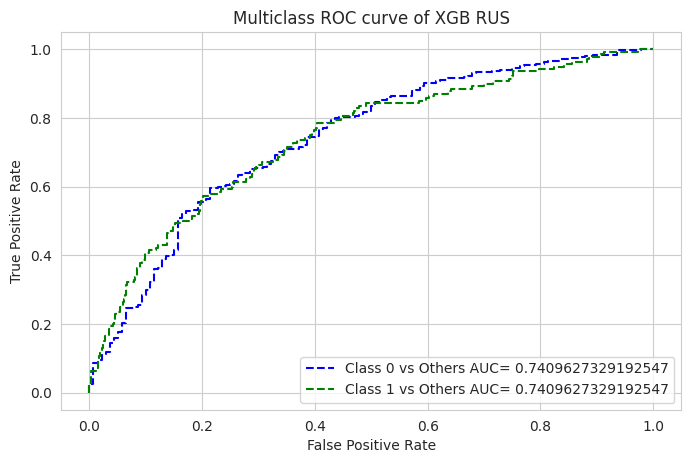



------ Evaluation on SMOTE data ------XGB SMOTE-----

------------------------- Test data -------------------------

Confusion matrix 



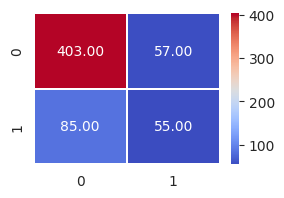


              precision    recall  f1-score   support

           0       0.83      0.88      0.85       460
           1       0.49      0.39      0.44       140

    accuracy                           0.76       600
   macro avg       0.66      0.63      0.64       600
weighted avg       0.75      0.76      0.75       600



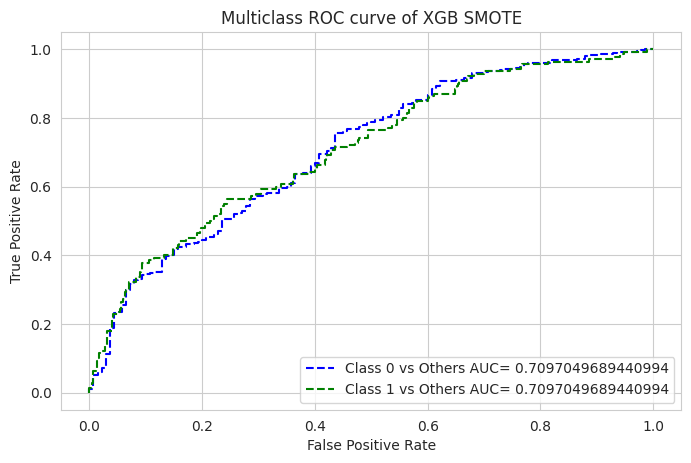

[{'Model_Name': 'XGB RUS',
  'Train_Accuracy': 0.9994807892004154,
  'Train_Recall': 0.9994807892004154,
  'Train_Precision': 0.9994813278008299,
  'Train_F1score': 0.9994807890604466,
  'Train_AUC': 1.0,
  'Test_Accuracy': 0.6666666666666666,
  'Test_Recall': 0.6666666666666666,
  'Test_Precision': 0.7586206896551724,
  'Test_F1score': 0.691183404054691,
  'Test_AUC': 0.7409627329192547},
 {'Model_Name': 'XGB SMOTE',
  'Train_Accuracy': 0.999127145766657,
  'Train_Recall': 0.999127145766657,
  'Train_Precision': 0.9991286668602963,
  'Train_F1score': 0.9991271451016509,
  'Train_AUC': 0.9999988148618693,
  'Test_Accuracy': 0.7633333333333333,
  'Test_Recall': 0.7633333333333333,
  'Test_Precision': 0.7477117486338798,
  'Test_F1score': 0.7536802625410222,
  'Test_AUC': 0.7097049689440994}]

In [100]:
#model evaluation of XGB
xgb_eval_list = model_evaluation('XGB RUS', 'XGB SMOTE',xgb_rus, xgb_smote,x_train_rus, y_train_rus, x_train_smote, y_train_smote)
xgb_eval_list

In [101]:
#adding list
add_list_to_final_df(xgb_eval_list)
comparison_df

Model_Name  Train_Accuracy  Train_Recall  \
0                     LogisticReg RUS        0.715992      0.715992   
1                   LogisticReg SMOTE        0.710358      0.710358   
2     Stochastic Gradient Descent RUS        0.593458      0.593458   
3   Stochastic Gradient Descent SMOTE        0.700902      0.700902   
4                       KNN Tuned RUS        0.733645      0.733645   
5                     KNN Tuned SMOTE        0.906168      0.906168   
6            Gaussian Naive Bayes RUS        0.686916      0.686916   
7          Gaussian Naive Bayes SMOTE        0.653477      0.653477   
8                   Decision Tree RUS        1.000000      1.000000   
9                 Decision Tree SMOTE        1.000000      1.000000   
10                  Random Forest RUS        0.751817      0.751817   
11                Random Forest SMOTE        0.756619      0.756619   
12                  RandomF Tuned RUS        0.830218      0.830218   
13                RandomF Tuned SMOTE        0.955921      0.955921   
14                            XGB RUS        0.999481      0.999481   
15                          XGB SMOTE        0.999127      0.999127   

    Train_Precision  Train_F1score  Train_AUC  Test_Accuracy  Test_Recall  \
0          0.728699       0.711991   0.783934       0.765000     0.765000   
1          0.719006       0.707470   0.776923       0.743333     0.743333   
2          0.664559       0.544226   0.751159       0.391667     0.391667   
3          0.714928       0.695941   0.770929       0.775000     0.775000   
4          0.746143       0.730220   0.802000       0.751667     0.751667   
5          0.917204       0.905544   0.987769       0.663333     0.663333   
6          0.701491       0.681150   0.750480       0.745000     0.745000   
7          0.668880       0.645391   0.747221       0.563333     0.563333   
8          1.000000       1.000000   1.000000       0.591667     0.591667   
9          1.000000       1.000000   1.000000       0.690000     0.690000   
10         0.763893       0.748945   0.842477       0.781667     0.781667   
11         0.764114       0.754880   0.842654       0.783333     0.783333   
12         0.831462       0.830059   0.918815       0.740000     0.740000   
13         0.955927       0.955921   0.992626       0.771667     0.771667   
14         0.999481       0.999481   1.000000       0.666667     0.666667   
15         0.999129       0.999127   0.999999       0.763333     0.763333   

    Test_Precision  Test_F1score  Test_AUC  
0         0.781711      0.771781  0.751755  
1         0.773094      0.754315  0.749984  
2         0.713301      0.388921  0.724891  
3         0.786171      0.779776  0.753261  
4         0.784509      0.763174  0.747943  
5         0.729058      0.684992  0.663385  
6         0.766838      0.753699  0.718168  
7         0.742724      0.594351  0.726196  
8         0.718658      0.623125  0.609472  
9         0.706675      0.697494  0.594099  
10        0.801425      0.789115  0.780435  
11        0.790042      0.786354  0.772888  
12        0.791539      0.755553  0.778773  
13        0.767764      0.769601  0.755186  
14        0.758621      0.691183  0.740963  
15        0.747712      0.753680  0.709705

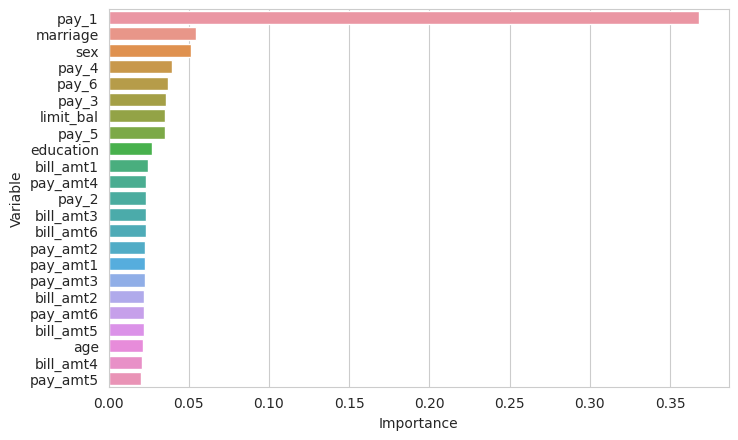

In [102]:
#visualising feature importance of XGB
feature_imp_xgb = pd.DataFrame({"Variable": df.columns[:-1],"Importance": xgb_smote.feature_importances_})
feature_imp_xgb.sort_values(by="Importance", ascending=False, inplace = True)
sns.barplot(x=feature_imp_xgb['Importance'], y= feature_imp_xgb['Variable'])
plt.show()

##**Evaluation Metrics:**

*   There is a number of model evaluation metrics to choose from but since our 
dataset was highly imbalanced, it is critical to understand which metric should be evaluated to understand the model performance.

*   Accuracy- Accuracy simply measures how often the classifier correctly predicts. We can define accuracy as the ratio of the number of correct predictions and the total number of predictions. Accuracy is useful when the target class is well balanced but is not a good choice for the unbalanced classes, because if the model poorly predicts every observation as of the majority class, we are going to get a pretty high accuracy.

*   Confusion Matrix - It is a performance measurement criteria for the machine learning classification problems where we get a table with a combination of predicted and actual values.

*   Precision - Precision for a label is defined as the number of true positives divided by the number of predicted positives.

*   Recall - Recall for a label is defined as the number of true positives divided by the total number of actual positives. Recall explains how many of the actual positive cases we were able to predict correctly with our model.

*   F1 Score - It's actually the harmonic mean of Precision and Recall. It is maximum when Precision is equal to Recall.

*   AUC ROC - The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes. When AUC is 0.5, the classifier is not able to distinguish between the classes and when it's closer to 1,the more good it becomes in distingushing them.


**So among all the above metrics, which metric should be prioritised in comparing the performance of our various models? That's the major question here as we have a multiclass classification problem, where the problem statement just asks us to track and classify between ignored, read and acknowledged classes, we can not decide here what we want to prioritise in terms of classification, we just want to correctly classify and characterize accordingly. On top of that our data is highly imbalanced, which we tried to encounter in the ways possible.**

**When we have a high class imbalance, we'll choose the F1 score because a high F1 score considers both precision and recall. To get a high F1, both false positives and false negatives must be low. The F1 score depends on how highly imbalanced our dataset is!**

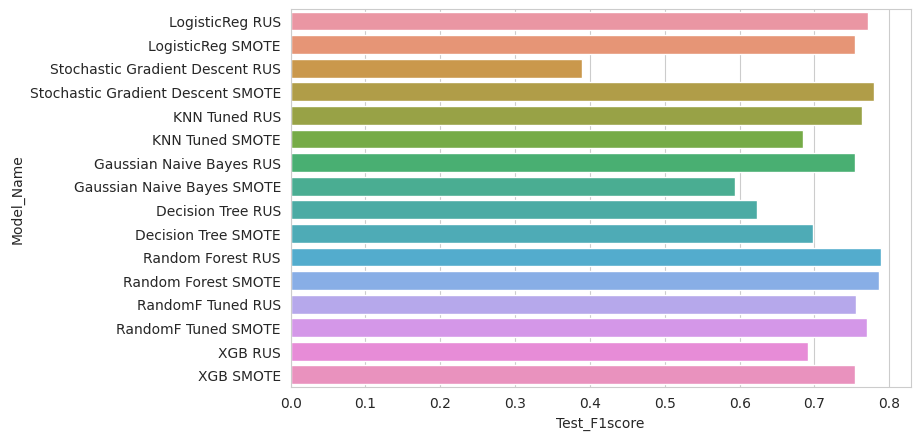

In [103]:
#visualising our comparison df for f1 score
sns.barplot(y=comparison_df['Model_Name'], x = comparison_df['Test_F1score'])
plt.show()

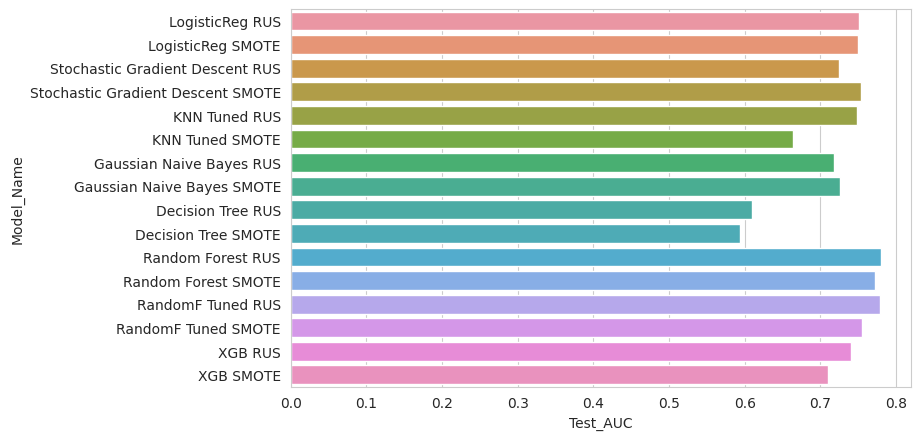

In [104]:
#visualising for auc
sns.barplot(y=comparison_df['Model_Name'], x = comparison_df['Test_AUC'])
plt.show()

In [105]:
#sorting values
comparison_df.sort_values(by=["Test_F1score",'Test_AUC'], ascending=(False,False), inplace = True, ignore_index = True)
comparison_df

Model_Name  Train_Accuracy  Train_Recall  \
0                   Random Forest RUS        0.751817      0.751817   
1                 Random Forest SMOTE        0.756619      0.756619   
2   Stochastic Gradient Descent SMOTE        0.700902      0.700902   
3                     LogisticReg RUS        0.715992      0.715992   
4                 RandomF Tuned SMOTE        0.955921      0.955921   
5                       KNN Tuned RUS        0.733645      0.733645   
6                   RandomF Tuned RUS        0.830218      0.830218   
7                   LogisticReg SMOTE        0.710358      0.710358   
8            Gaussian Naive Bayes RUS        0.686916      0.686916   
9                           XGB SMOTE        0.999127      0.999127   
10                Decision Tree SMOTE        1.000000      1.000000   
11                            XGB RUS        0.999481      0.999481   
12                    KNN Tuned SMOTE        0.906168      0.906168   
13                  Decision Tree RUS        1.000000      1.000000   
14         Gaussian Naive Bayes SMOTE        0.653477      0.653477   
15    Stochastic Gradient Descent RUS        0.593458      0.593458   

    Train_Precision  Train_F1score  Train_AUC  Test_Accuracy  Test_Recall  \
0          0.763893       0.748945   0.842477       0.781667     0.781667   
1          0.764114       0.754880   0.842654       0.783333     0.783333   
2          0.714928       0.695941   0.770929       0.775000     0.775000   
3          0.728699       0.711991   0.783934       0.765000     0.765000   
4          0.955927       0.955921   0.992626       0.771667     0.771667   
5          0.746143       0.730220   0.802000       0.751667     0.751667   
6          0.831462       0.830059   0.918815       0.740000     0.740000   
7          0.719006       0.707470   0.776923       0.743333     0.743333   
8          0.701491       0.681150   0.750480       0.745000     0.745000   
9          0.999129       0.999127   0.999999       0.763333     0.763333   
10         1.000000       1.000000   1.000000       0.690000     0.690000   
11         0.999481       0.999481   1.000000       0.666667     0.666667   
12         0.917204       0.905544   0.987769       0.663333     0.663333   
13         1.000000       1.000000   1.000000       0.591667     0.591667   
14         0.668880       0.645391   0.747221       0.563333     0.563333   
15         0.664559       0.544226   0.751159       0.391667     0.391667   

    Test_Precision  Test_F1score  Test_AUC  
0         0.801425      0.789115  0.780435  
1         0.790042      0.786354  0.772888  
2         0.786171      0.779776  0.753261  
3         0.781711      0.771781  0.751755  
4         0.767764      0.769601  0.755186  
5         0.784509      0.763174  0.747943  
6         0.791539      0.755553  0.778773  
7         0.773094      0.754315  0.749984  
8         0.766838      0.753699  0.718168  
9         0.747712      0.753680  0.709705  
10        0.706675      0.697494  0.594099  
11        0.758621      0.691183  0.740963  
12        0.729058      0.684992  0.663385  
13        0.718658      0.623125  0.609472  
14        0.742724      0.594351  0.726196  
15        0.713301      0.388921  0.724891

#Conclusion

**Modeling:**


*   Imbalanced Class Handling techniques such as Undersampling and SMOTE were done after train-test split only on the training data, to make sure that the model doesn't catch up to the test set at all and it remains unknown which somewhat reduced our results.

*   It is observed that SMOTE worked considerably better than Random Undersampling, it may have led to loss of information.

*   Decision Tree Model is overfitting. It is working really great on train data and worse on test data.

*   Hyperparameter tuning isn't improving the results to a great degree.

*   Random Forest Hyperparameter Tuned worked in the best way possible with such imbalanced data with outliers, followed by XGBoost Algorithm model with F1 Score of 0.789 on the test set.


**Important Results**

1)Using a Logistic Regression classifier, we can predict with 0.765 recall with Logistic RUS and 0.738 with Logistic SMOTE, whether a customer is likely to default next month.

2)Using a Stochastic Gradient Descent classifier, we can predict with 0.391 recall with Stochastic Gradient Descent RUC and 0.750 with Stochastic Gradient Descent SMOTE, whether a customer is likely to default next month.

3)Using a K-Nearest Neighbour Hyperparameter Tuning, we can predict with with 0.751 recall with  K-Nearest Neighbour Hyperparameter Tuning RUC and 0.655 with  K-Nearest Neighbour Hyperparameter Tuning SMOTE, whether a customer is likely to default next month.

4)Using a Decision Tree classifier, we can predict with with 0.591 recall with Decision Tree RUC and 0.696 with Decision Tree SMOTE, whether a customer is likely to default next month.

5)Using a Random Forest classifier, we can predict with with 0.745 recall with Random Forest RUC and 0.620 with Random Forest, whether a customer is likely to default next month.

6)Using a Random Forest Hyperparameter Tuning, we can predict with with 0.620 recall with Random Forest Hyperparameter Tuning RUC and 0.768 with Random Forest Hyperparameter Tuning SMOTE, whether a customer is likely to default next month.

7)Using a XGBOOST classifier, we can predict with with 0.666 accuracy with XGBOOST RUC and 0.773 with XGBOOST SMOTE, whether a customer is likely to default next month.

The strongest predictors of default are the PAY_X (ie the repayment status in previous months), the LIMIT_BAL & the PAY_AMTX (amount paid in previous months).

We found that using Stochastic Gradient Descent and Decision Tree are worst.

Demographics: we see that being Female, More educated, Single and between 30-40years old means a customer is more likely to make payments on time.